# IS453 Financial Analytics Group Project - Creating a Scorecard for Lending
## Credit risk scorecard construction with scorecardpy

<h1>Installation of Packages</h

**Install scorecardpy**
This is a python version of R package scorecard. The API link has more info :
https://pypi.org/project/scorecardpy/
https://github.com/shichenxie/scorecardpy/
https://cran.r-project.org/web/packages/scorecard/scorecard.pdf

In [2]:
!pip3 install pandas==1.3.5
!pip3 install scorecardpy==0.1.9.3
!pip3 install ipython
# after downloading, restart your kernel
!pip3 install git+https://github.com/ShichenXie/scorecardpy.git


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
  Cloning https://github.com/ShichenXie/scorecardpy.git to /private/var/folders/fk/4bq05fp97mg5w3g0pnlnf1540000gn/T/pip-req-build-twbmyw5y
  Running command git clone --filter=blob:none --quiet https://github.com/ShichenXie/scorecardpy.git /private/var/folders/fk/4bq05fp97mg5w3g0pnlnf1540000gn/T/pip-req-build-twbmyw5y
  Resolved https://github.com/ShichenXie/scorecardpy.git to commit 2f28b47b70086b30d253ac13670c452f0c654f03
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


<h3>Importing Python modules and packagaes</h

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import scorecardpy as sc
import pprint
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

<h3>Reading CSV file for Customer Loan Data</h3>
The customer loan data is filtered with only the selected occupation types (Laborers, Cleaner and etc) and the bottom 25% of the income total for each occupation

In [4]:
# reading customer loan data from csv file
raw_customer_loan_data = pd.read_csv('new_credit_data_all_col.csv')

In [5]:
# Inspecting the customer loan data
raw_customer_loan_data.head(5)

,STATUS,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
0,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52.0
1,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,46.0
2,0,Cash loans,F,N,Y,0,67500.0,80865.0,5881.5,67500.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,37.0
3,0,Revolving loans,F,N,Y,1,81000.0,270000.0,13500.0,270000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,27.0
4,0,Revolving loans,F,N,Y,0,112500.0,157500.0,7875.0,157500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,49.0


In [6]:
# inspecting the shape of the dataset for the rows and columns numbers
raw_customer_loan_data.shape

(19007, 75)

In [7]:
# inspecting the missing data in each column
raw_customer_loan_data.isna().sum()

STATUS                           0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_WEEK    3488
AMT_REQ_CREDIT_BUREAU_MON     3488
AMT_REQ_CREDIT_BUREAU_QRT     3488
AMT_REQ_CREDIT_BUREAU_YEAR    3488
AGE                              0
Length: 75, dtype: int64

In [8]:
# inspecting if there is any rows that has more than missing 80% of total data in a row 
raw_customer_loan_data.loc[raw_customer_loan_data.isna().mean(axis=1)>0.8].count()

STATUS                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
AGE                           0
Length: 75, dtype: int64

In [9]:
# declaring the numerical and categorical variables in the dataset
numerical_column = ['OBS_60_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS','AMT_CREDIT', 'AMT_ANNUITY', 'CNT_CHILDREN', 'AMT_GOODS_PRICE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'DAYS_REGISTRATION', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'REGION_RATING_CLIENT',  'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE']


categorical_column = ['STATUS', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE']

<h1>Dividing the data into training and testing data, and split it into numerical and categorical</h3>

In [10]:
customer_loan_data = raw_customer_loan_data.copy()
customer_loan_data_X = customer_loan_data.drop('STATUS', axis = 1)
customer_loan_data_y = customer_loan_data['STATUS']

# ensuring categorical and numerical data are properly formatted with the correct data type
customer_loan_data_X = customer_loan_data_X.astype({'FLAG_MOBIL': 'object', 'FLAG_EMP_PHONE': 'object', 'FLAG_WORK_PHONE': 'object', 'FLAG_CONT_MOBILE': 'object', 'FLAG_PHONE': 'object','FLAG_EMAIL': 'object','REGION_RATING_CLIENT': 'object','REGION_RATING_CLIENT_W_CITY': 'object','REG_REGION_NOT_LIVE_REGION': 'object','REG_REGION_NOT_WORK_REGION': 'object','LIVE_REGION_NOT_WORK_REGION': 'object', 'REG_CITY_NOT_LIVE_CITY': 'object','REG_CITY_NOT_WORK_CITY': 'object','LIVE_CITY_NOT_WORK_CITY': 'object','LIVE_REGION_NOT_WORK_REGION': 'object', 'FLAG_DOCUMENT_2': 'object', 'FLAG_DOCUMENT_3': 'object', 'FLAG_DOCUMENT_4': 'object', 'FLAG_DOCUMENT_5': 'object', 'FLAG_DOCUMENT_6': 'object','FLAG_DOCUMENT_7': 'object', 'FLAG_DOCUMENT_8': 'object','FLAG_DOCUMENT_9': 'object','FLAG_DOCUMENT_10': 'object','FLAG_DOCUMENT_11': 'object','FLAG_DOCUMENT_12': 'object','FLAG_DOCUMENT_13': 'object','FLAG_DOCUMENT_14': 'object','FLAG_DOCUMENT_21': 'object','FLAG_DOCUMENT_15': 'object','FLAG_DOCUMENT_16': 'object','FLAG_DOCUMENT_17': 'object','FLAG_DOCUMENT_18': 'object','FLAG_DOCUMENT_19': 'object','FLAG_DOCUMENT_20': 'object'})

# first divide training data into categorical and numerical subsets
# may be flawed cause categorical data with 1 and 0 also counted as numerical here 
customer_loan_data_X_category = customer_loan_data_X.select_dtypes(include = 'object').copy()
customer_loan_data_X_numeric = customer_loan_data_X.select_dtypes(include = 'number').copy()

# define an empty dictionary to store chi-squared test results
chi_squared_results = {}

In [11]:
# inspecting the datatype if numerical data and categorical data are properly formatted
customer_loan_data_X.dtypes
customer_loan_data_X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19007 entries, 0 to 19006
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NAME_CONTRACT_TYPE           19007 non-null  object 
 1   CODE_GENDER                  19007 non-null  object 
 2   FLAG_OWN_CAR                 19007 non-null  object 
 3   FLAG_OWN_REALTY              19007 non-null  object 
 4   CNT_CHILDREN                 19007 non-null  int64  
 5   AMT_INCOME_TOTAL             19007 non-null  float64
 6   AMT_CREDIT                   19007 non-null  float64
 7   AMT_ANNUITY                  19006 non-null  float64
 8   AMT_GOODS_PRICE              18975 non-null  float64
 9   NAME_TYPE_SUITE              18937 non-null  object 
 10  NAME_INCOME_TYPE             19007 non-null  object 
 11  NAME_EDUCATION_TYPE          19007 non-null  object 
 12  NAME_FAMILY_STATUS           19007 non-null  object 
 13  NAME_HOUSING_TYP

<h1>Performing Correlation Analysis using ChiSquare, Anova F-Test and Heatmap Correlation Analysis</h3

In [12]:
# loop over each column in the training set to calculate chi-statistic with the target variable
for column in customer_loan_data_X_category:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(customer_loan_data_y, customer_loan_data_X_category[column]))
    chi_squared_results.setdefault('Feature',[]).append(column)
    chi_squared_results.setdefault('p-value',[]).append(round(p, 10))

In [13]:
# convert the dictionary to a DF
chi_squared_results = pd.DataFrame(data = chi_squared_results)
chi_squared_results.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi_squared_results

,Feature,p-value
0,REG_CITY_NOT_LIVE_CITY,0.000000e+00
1,CODE_GENDER,0.000000e+00
2,REG_CITY_NOT_WORK_CITY,0.000000e+00
3,REGION_RATING_CLIENT_W_CITY,0.000000e+00
4,REGION_RATING_CLIENT,0.000000e+00
5,NAME_FAMILY_STATUS,1.000000e-10
6,FLAG_OWN_CAR,9.460000e-08
7,FLAG_DOCUMENT_3,1.898500e-06
8,OCCUPATION_TYPE,3.461000e-06
9,NAME_INCOME_TYPE,1.068820e-05


In [14]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
customer_loan_data_X_numeric.fillna(customer_loan_data_X_numeric.median(), inplace = True)

In [15]:
# Calculate F Statistic and corresponding p values
f_stats, p_values = f_classif(customer_loan_data_X_numeric, customer_loan_data_y)

In [16]:
# convert to a DF
ANOVA_F_results = pd.DataFrame(data = {'Numerical_Feature': customer_loan_data_X_numeric.columns.values,
                                       'F-Score': f_stats, 'p values': p_values.round(decimals=10)})
ANOVA_F_results.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_results

,Numerical_Feature,F-Score,p values
0,EXT_SOURCE_2,604.331977,0.000000e+00
1,EXT_SOURCE_3,516.722064,0.000000e+00
2,EXT_SOURCE_1,167.969542,0.000000e+00
3,DAYS_LAST_PHONE_CHANGE,154.171064,0.000000e+00
4,YEARS_EMPLOYED,131.216931,0.000000e+00
5,AGE,126.877409,0.000000e+00
6,DAYS_REGISTRATION,51.550455,0.000000e+00
7,DAYS_ID_PUBLISH,28.333501,1.033000e-07
8,DEF_30_CNT_SOCIAL_CIRCLE,23.472309,1.277200e-06
9,DEF_60_CNT_SOCIAL_CIRCLE,18.410977,1.789090e-05


In [17]:
# Select the Top 20 Numerical Feature based on F-Score
top_20_features = ANOVA_F_results.iloc[:20,0].to_list()
top_20_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'DAYS_LAST_PHONE_CHANGE',
 'YEARS_EMPLOYED',
 'AGE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'REGION_POPULATION_RELATIVE',
 'AMT_ANNUITY',
 'APARTMENTS_AVG',
 'HOUR_APPR_PROCESS_START',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'OWN_CAR_AGE',
 'AMT_CREDIT',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL']

<AxesSubplot: >

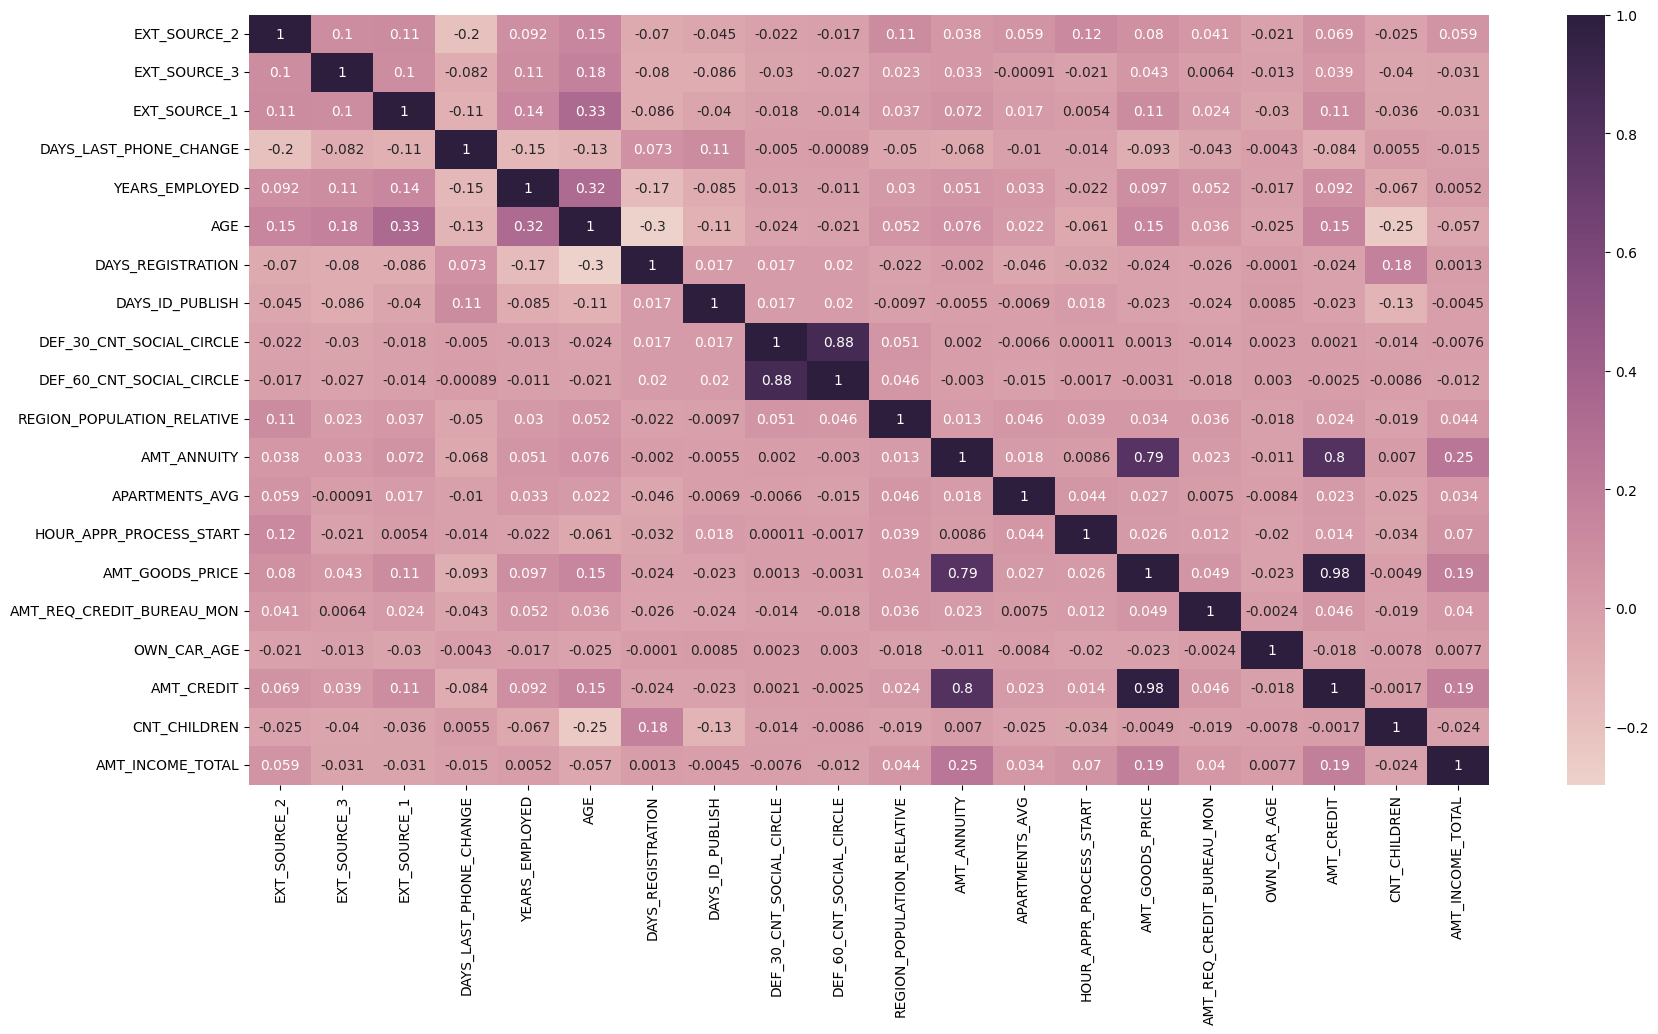

In [18]:
# calculate pair-wise correlations between them
corrmat = customer_loan_data_X_numeric[top_20_features].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corrmat, cmap=sns.cubehelix_palette(as_cmap=True), annot=True)

In [19]:
# There is no highly correlated columns within the dataset, therefore all the columns will be considered in the following analysis

# Get WOE and IV for Logistic Regression

In [20]:
# creating woe binnning for customer loan data
bins = sc.woebin(customer_loan_data, y='STATUS')

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Binning on 19007 rows and 72 columns in 00:00:23


In [21]:
# calculate total IV for each variable
iv_df = pd.DataFrame(columns=['Variable', 'Variable IV',])
for variables, bindetails in bins.items():
    variables_iv = bindetails.loc[0,'total_iv']
    iv_df = iv_df.append({'Variable': variables, 'Variable IV': variables_iv}, ignore_index=True)

<h3>Sorting the columns by IV value for feature selection

In [22]:
# sort IV dataframe by Total IV in descending order
iv_df = iv_df.sort_values(by='Variable IV', ascending=False,ignore_index=True)

# display sorted IV dataframe
print(iv_df.head(50))

                       Variable  Variable IV
0                  EXT_SOURCE_3     0.314928
1                  EXT_SOURCE_2     0.291352
2                  EXT_SOURCE_1     0.128903
3        DAYS_LAST_PHONE_CHANGE     0.095030
4                YEARS_EMPLOYED     0.093025
5                           AGE     0.075688
6                    AMT_CREDIT     0.057824
7               AMT_GOODS_PRICE     0.055022
8   REGION_RATING_CLIENT_W_CITY     0.042978
9                   CODE_GENDER     0.042294
10         REGION_RATING_CLIENT     0.041724
11                  AMT_ANNUITY     0.035622
12            DAYS_REGISTRATION     0.035523
13   REGION_POPULATION_RELATIVE     0.032936
14                  OWN_CAR_AGE     0.031336
15            ORGANIZATION_TYPE     0.030911
16               APARTMENTS_AVG     0.028484
17   AMT_REQ_CREDIT_BUREAU_YEAR     0.027089
18       REG_CITY_NOT_LIVE_CITY     0.027024
19           NAME_FAMILY_STATUS     0.025716
20    AMT_REQ_CREDIT_BUREAU_MON     0.024759
21    AMT_

<h2> Initial 15 Characteristics </h3>

In [23]:
customer_loan_data.columns

Index(['STATUS', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'OBS_30_CNT_SOC

In [24]:
# list of columns to be dropped from the original set 
not_keep_list = ['STATUS', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE']

In [25]:
# List of variables to be used in model training

adj_keep_list =['STATUS','EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AGE', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'AMT_ANNUITY',
                'DAYS_REGISTRATION','NAME_INCOME_TYPE','AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE']

#  if the column is not in the keep list, the columns will be dropped from the customer loan data
drop_list = [col for col in customer_loan_data.columns if col not in adj_keep_list]
final_customer_loan_data = customer_loan_data.drop(columns=drop_list,inplace=False)

In [26]:
# inspecting the columns after filtering the features 
final_customer_loan_data.columns

Index(['STATUS', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE',
       'YEARS_EMPLOYED', 'DAYS_REGISTRATION', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'AGE'],
      dtype='object')

In [27]:
#Replacing the missing values with np.nan and drop na values from the final customer loan data

final_customer_loan_data.replace('Missing', np.nan, inplace=True)
final_customer_loan_data.dropna(subset=['STATUS','EXT_SOURCE_3', 'EXT_SOURCE_2', 
                'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AGE', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 
                'AMT_ANNUITY','DAYS_REGISTRATION','NAME_INCOME_TYPE',
                'AMT_INCOME_TOTAL'], inplace=True)

### After selecting 15 columns with the highest IV Values

In [28]:
# creating woe bin based on the 15 selected columns/ features 
bins3 = sc.woebin(final_customer_loan_data, y='STATUS')

[INFO] creating woe binning ...


In [29]:
# calculate total IV for each variable
iv_df2 = pd.DataFrame(columns=['Variable', 'Variable IV',])
for variables, bindetails in bins3.items():
    variables_iv = bindetails.loc[0,'total_iv']
    iv_df2 = iv_df2.append({'Variable': variables, 'Variable IV': variables_iv}, ignore_index=True)

# sort IV dataframe by Total IV in descending order
iv_df2 = iv_df2.sort_values(by='Variable IV', ascending=False,ignore_index=True)

# display sorted IV dataframe
print(iv_df2)

                       Variable  Variable IV
0                  EXT_SOURCE_3     0.508267
1                  EXT_SOURCE_1     0.301023
2                  EXT_SOURCE_2     0.246114
3                           AGE     0.126176
4        DAYS_LAST_PHONE_CHANGE     0.094473
5               AMT_GOODS_PRICE     0.072548
6                    AMT_CREDIT     0.071174
7                YEARS_EMPLOYED     0.056935
8    REGION_POPULATION_RELATIVE     0.054699
9                   AMT_ANNUITY     0.054608
10            DAYS_REGISTRATION     0.031676
11  REGION_RATING_CLIENT_W_CITY     0.030434
12         REGION_RATING_CLIENT     0.028816
13             AMT_INCOME_TOTAL     0.021572
14             NAME_INCOME_TYPE     0.001227


{'AGE': <Figure size 640x480 with 2 Axes>,
 'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'AMT_INCOME_TOTAL': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'NAME_INCOME_TYPE': <Figure size 640x480 with 2 Axes>,
 'DAYS_REGISTRATION': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>}

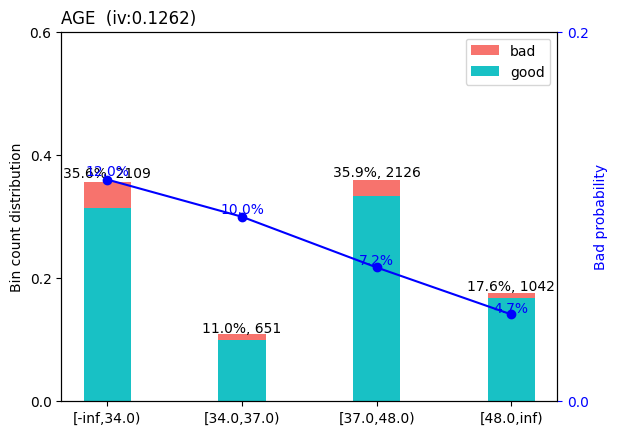

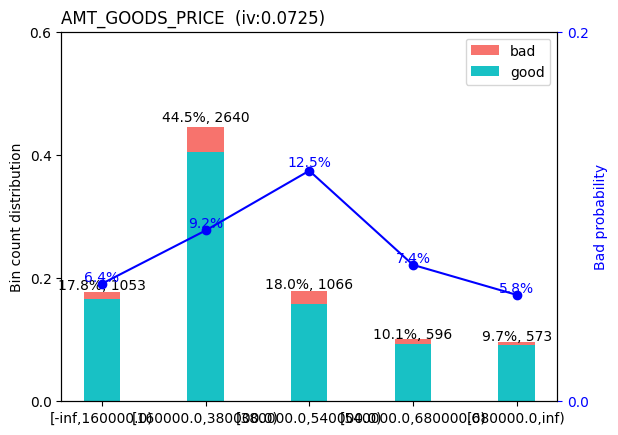

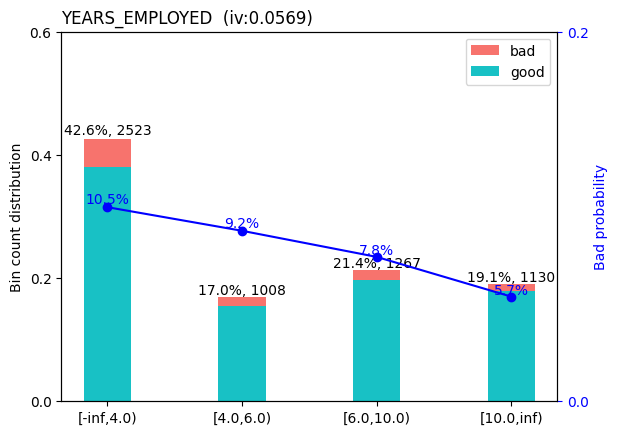

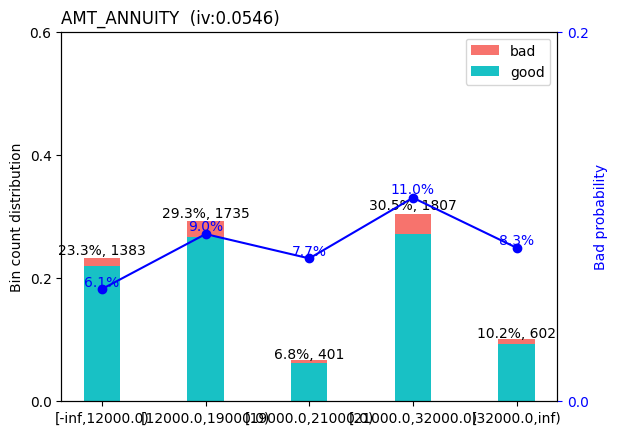

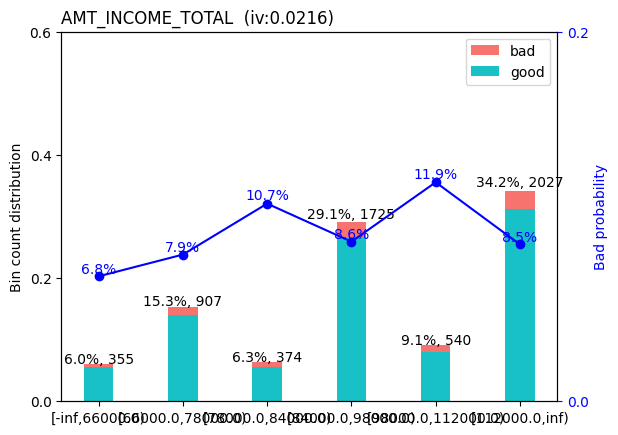

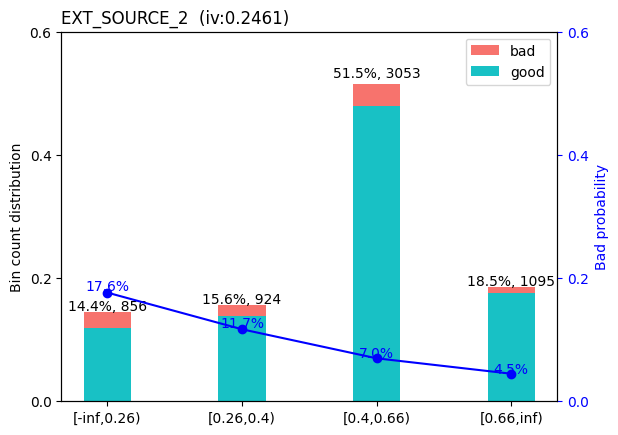

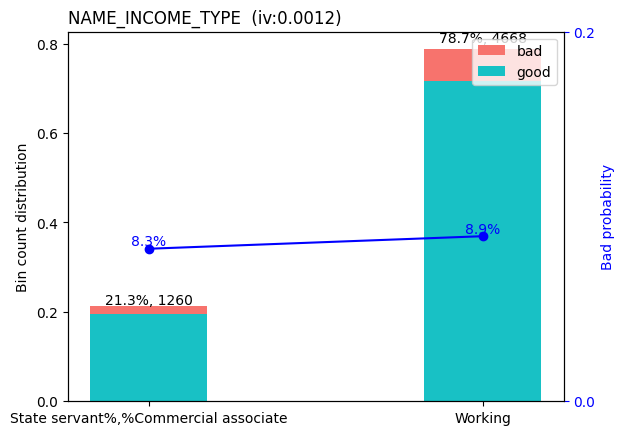

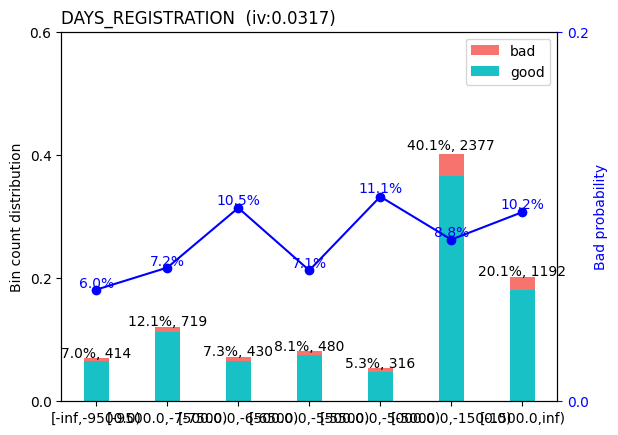

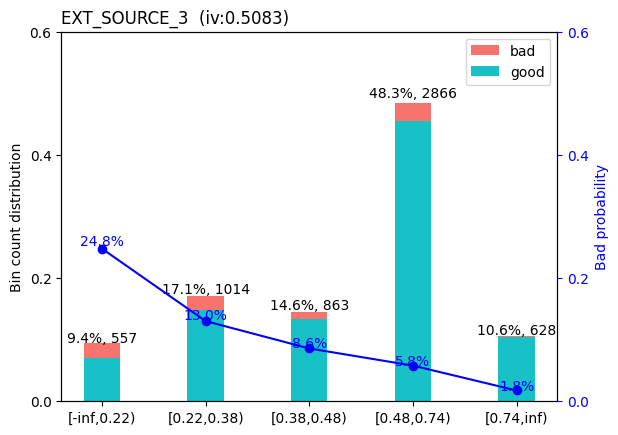

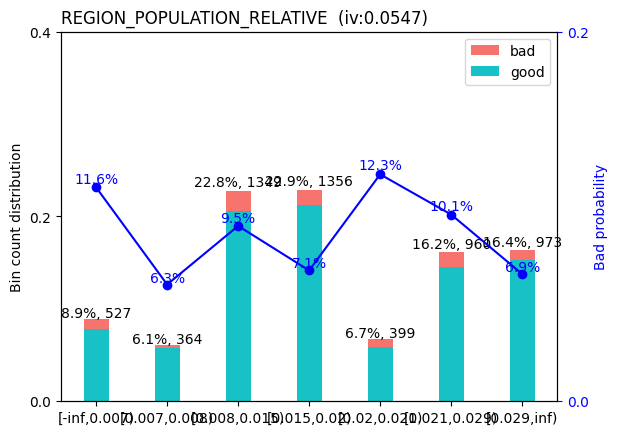

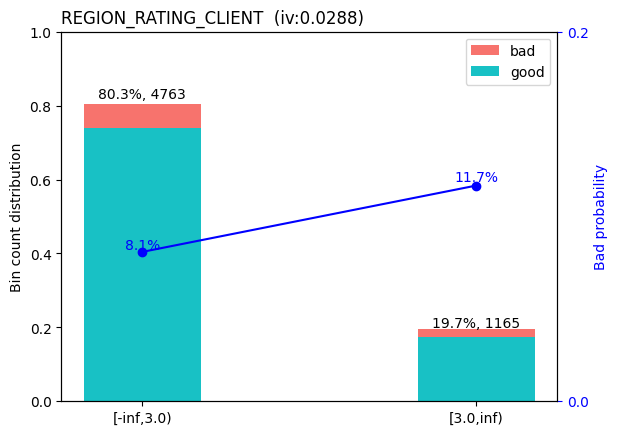

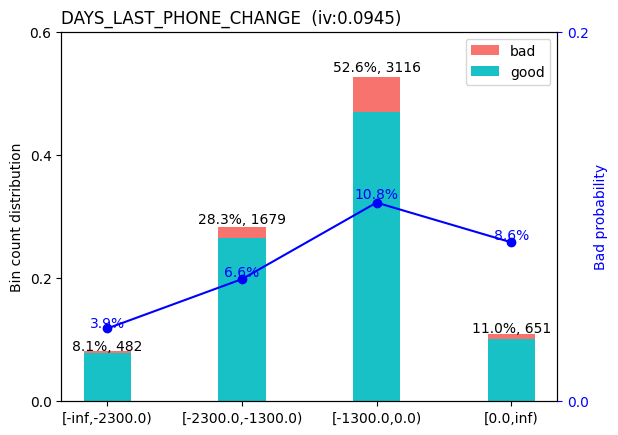

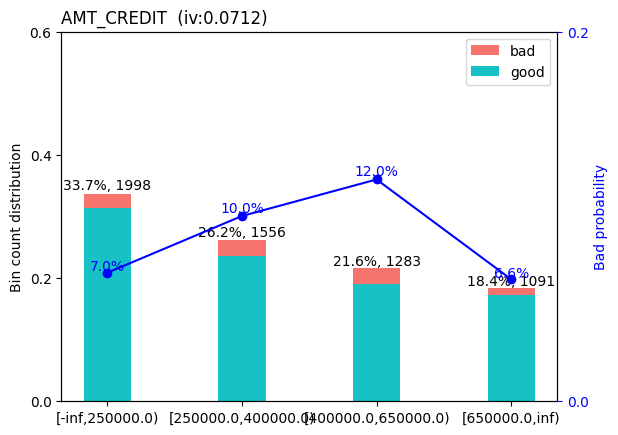

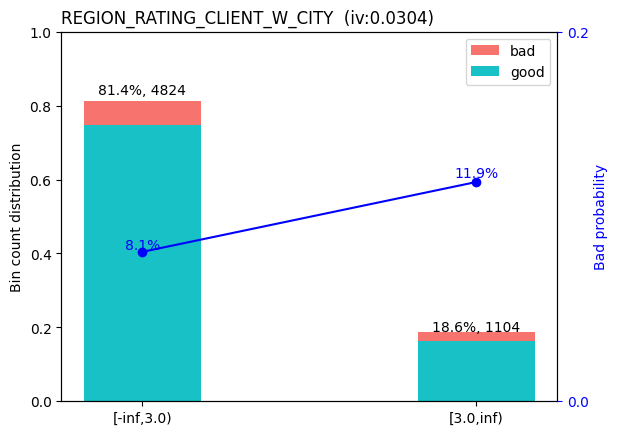

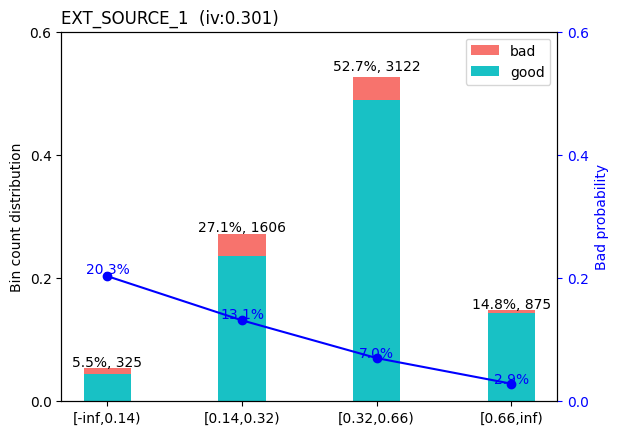

In [30]:
# visualise the woe binning after selected the features
sc.woebin_plot(bins3)

**Non Monotonic Variable**

1. AMT_GOODS_PRICE 
2. REGION_POPULATION_RELATIVE 
3. AMT_INCOME_TOTAL 
4. DAYS_LAST_PHONE_CHANGE 
5. DAYS_REGISTRATION 
6. AMT_CREDIT 
**ADJUSTMENT**

**1. Manual adjustment of AMT_GOODS_PRICE groupings**

{'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>}

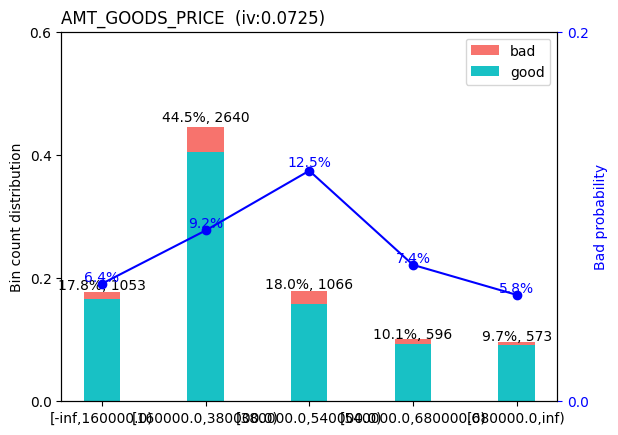

In [31]:
sc.woebin_plot(bins3['AMT_GOODS_PRICE'])

[INFO] creating woe binning ...


{'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>}

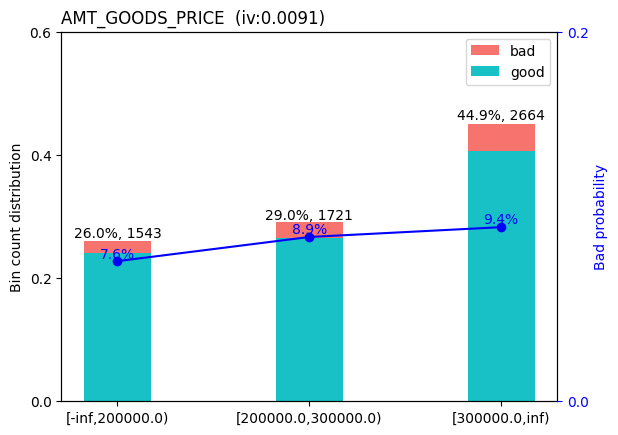

In [32]:
# drop to 3 bins
breaks_adj = {'AMT_GOODS_PRICE' : [14000,200000, 300000]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['AMT_GOODS_PRICE'])

**2. Manual adjustment of REGION_POPULATION_RELATIVE groupings**

{'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>}

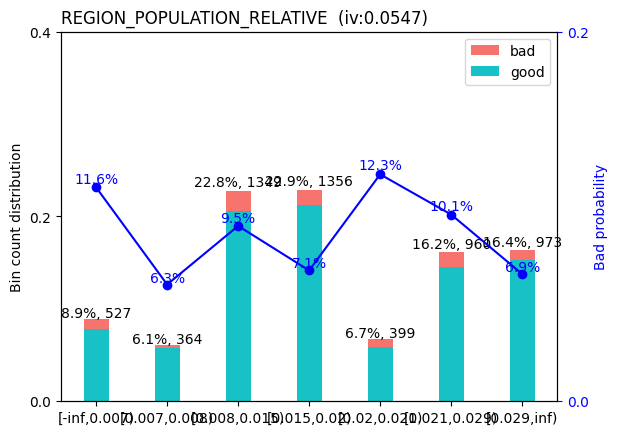

In [33]:
sc.woebin_plot(bins3['REGION_POPULATION_RELATIVE'])

[INFO] creating woe binning ...


{'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>}

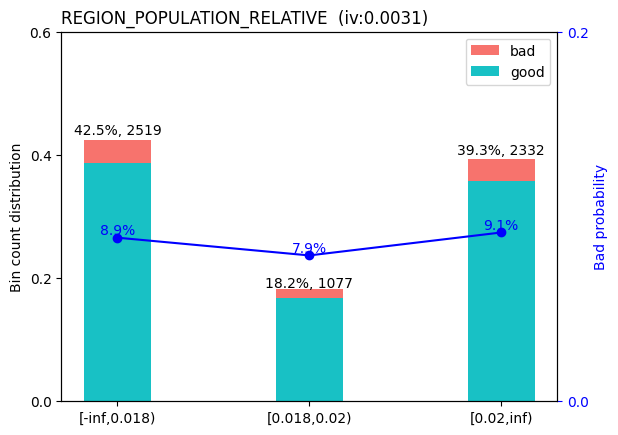

In [34]:
# drop to 3 bins
breaks_adj = {'REGION_POPULATION_RELATIVE' : [0.018 ,0.02]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['REGION_POPULATION_RELATIVE'])

**3. Manual adjustment of AMT_INCOME_TOTAL groupings**

{'AMT_INCOME_TOTAL': <Figure size 640x480 with 2 Axes>}

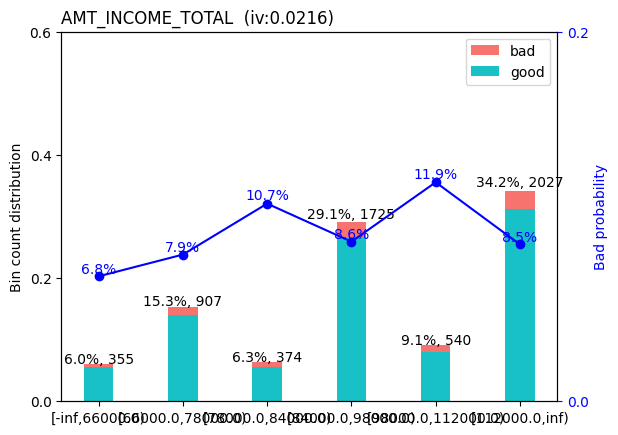

In [35]:
sc.woebin_plot(bins3['AMT_INCOME_TOTAL'])

[INFO] creating woe binning ...


{'AMT_INCOME_TOTAL': <Figure size 640x480 with 2 Axes>}

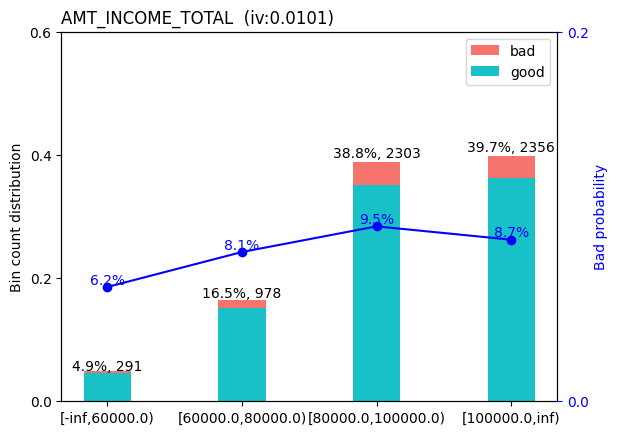

In [36]:
# drop to 4 bins
breaks_adj = {'AMT_INCOME_TOTAL' : [60000,80000,100000]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['AMT_INCOME_TOTAL'])

**4. Manual adjustment of DAYS_LAST_PHONE_CHANGE groupings**

{'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>}

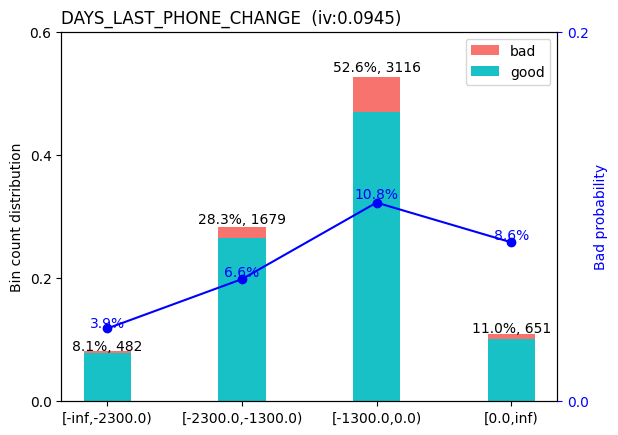

In [37]:
sc.woebin_plot(bins3['DAYS_LAST_PHONE_CHANGE'])

[INFO] creating woe binning ...


{'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>}

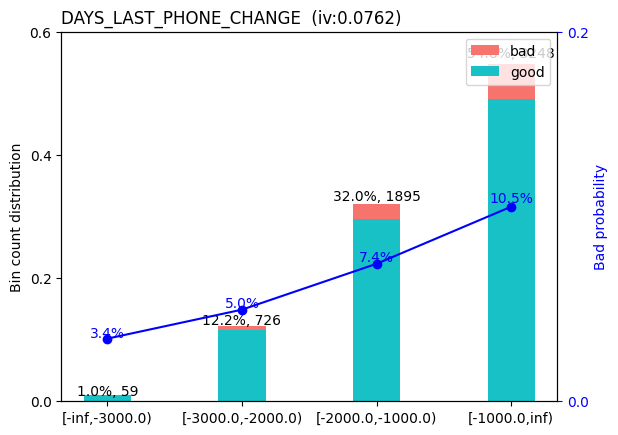

In [38]:
# drop to 4 bins
breaks_adj = {'DAYS_LAST_PHONE_CHANGE' : [-3000,-2000,-1000]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['DAYS_LAST_PHONE_CHANGE'])

**5. Manual adjustment of DAYS_REGISTRATION groupings**

{'DAYS_REGISTRATION': <Figure size 640x480 with 2 Axes>}

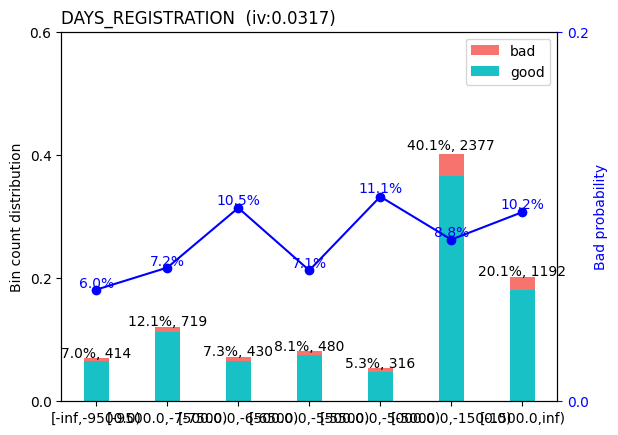

In [39]:
sc.woebin_plot(bins3['DAYS_REGISTRATION'])

[INFO] creating woe binning ...


{'DAYS_REGISTRATION': <Figure size 640x480 with 2 Axes>}

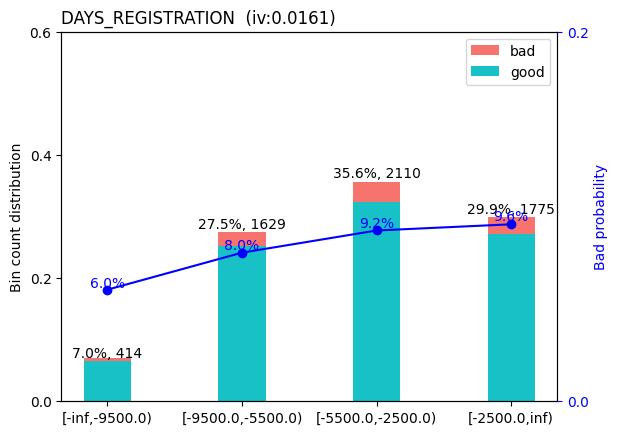

In [40]:
# drop to 4 bins
breaks_adj = {'DAYS_REGISTRATION' : [-9500.0,-5500.0,-2500.0]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['DAYS_REGISTRATION'])

**6. Manual adjustment of AMT_CREDIT groupings**

{'AMT_CREDIT': <Figure size 640x480 with 2 Axes>}

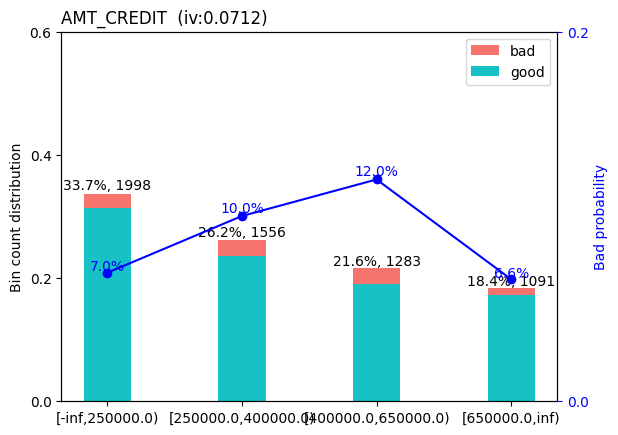

In [41]:
sc.woebin_plot(bins3['AMT_CREDIT'])

[INFO] creating woe binning ...


{'AMT_CREDIT': <Figure size 640x480 with 2 Axes>}

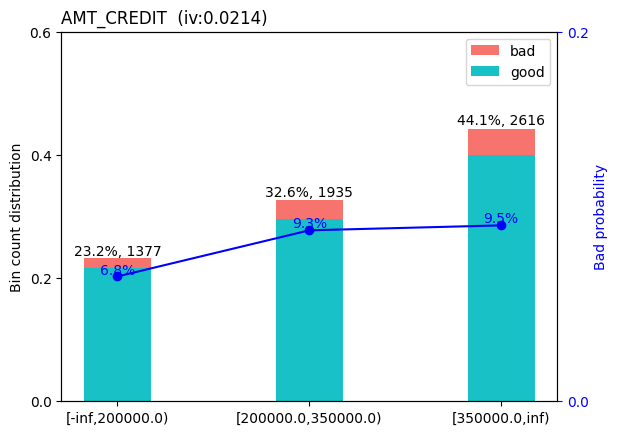

In [42]:
# drop to 3 bins
breaks_adj = {'AMT_CREDIT' : [200000,350000]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['AMT_CREDIT'])

**7. Manual adjustment of AMT_ANNUITY groupings**

{'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>}

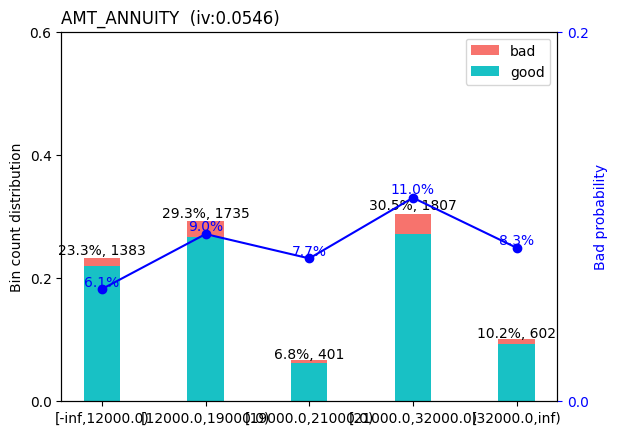

In [43]:
sc.woebin_plot(bins3['AMT_ANNUITY'])

[INFO] creating woe binning ...


{'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>}

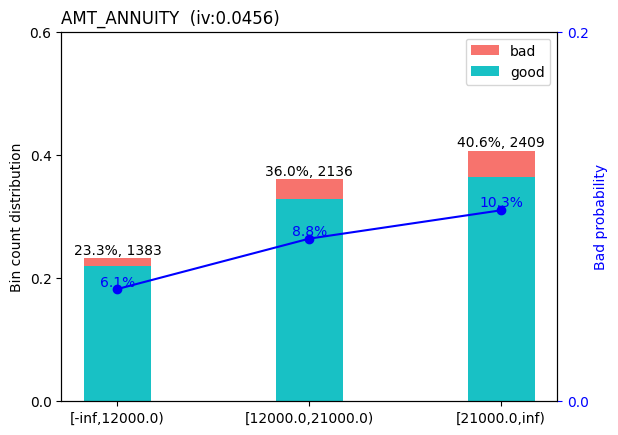

In [44]:
# your code here
breaks_adj = {'AMT_ANNUITY' : [12000,21000]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2['AMT_ANNUITY'])

*** SUMMARY ***

1. AMT_GOODS_PRICE: 6 bins to 3 bins
2. REGION_POPULATION_RELATIVE; : 7 bins to 3 bins
3. AMT_INCOME_TOTAL: 5 bins to 4 bins
4. DAYS_LAST_PHONE_CHANGE : 8 to 4 bins
5. DAYS_REGISTRATION: 7 bins to 4 bins
6. AMT_CREDIT: 8 to 3 bins
7. AMT_ANNUITY:5 to 3 bins
**All COMBINED**

[INFO] creating woe binning ...


{'AGE': <Figure size 640x480 with 2 Axes>,
 'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'AMT_INCOME_TOTAL': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'NAME_INCOME_TYPE': <Figure size 640x480 with 2 Axes>,
 'DAYS_REGISTRATION': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>}

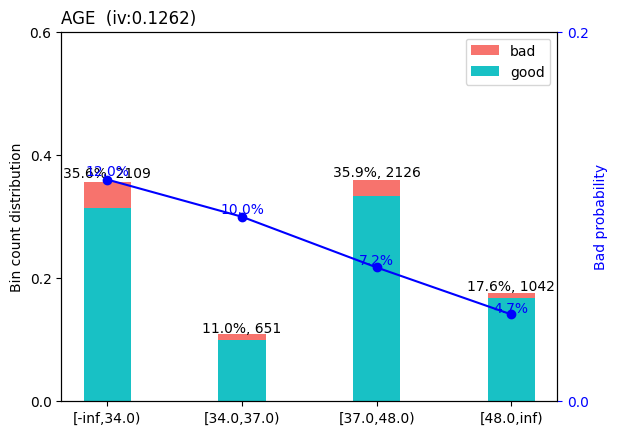

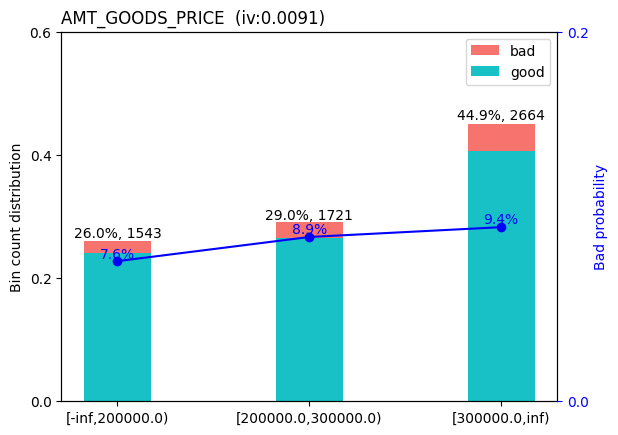

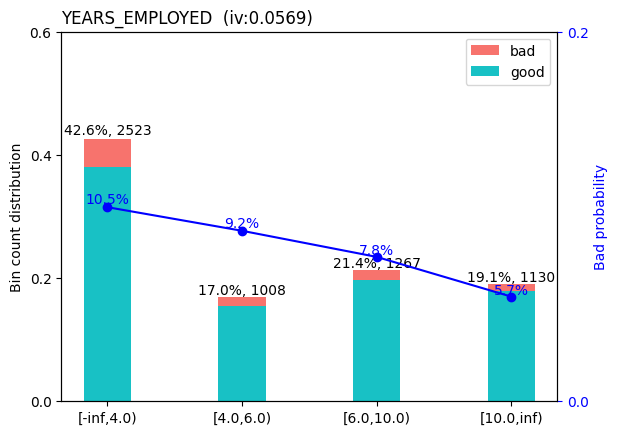

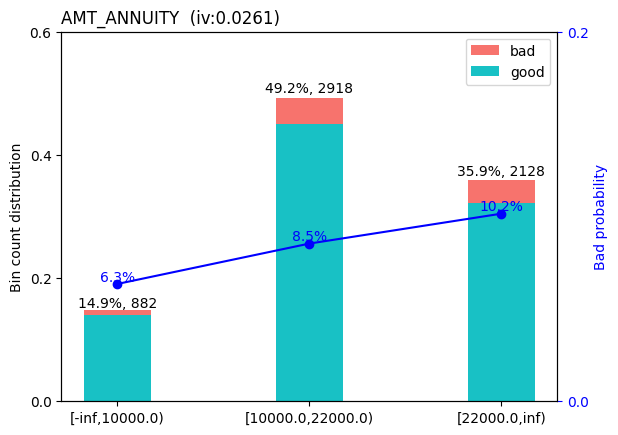

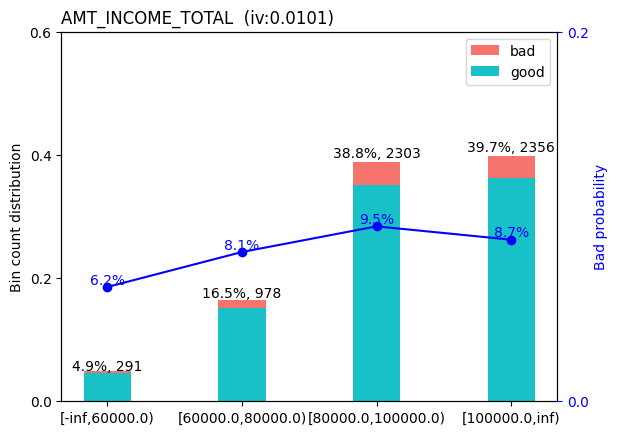

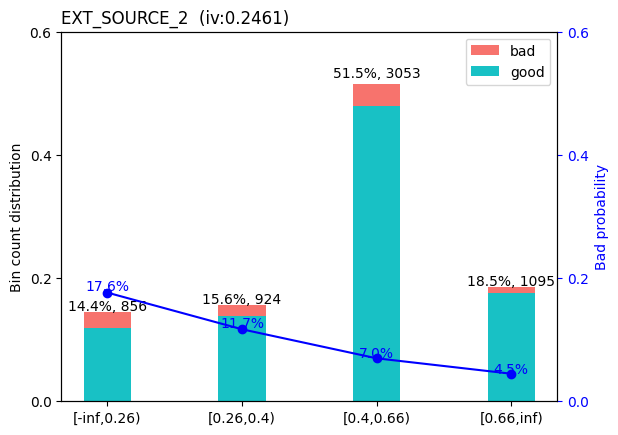

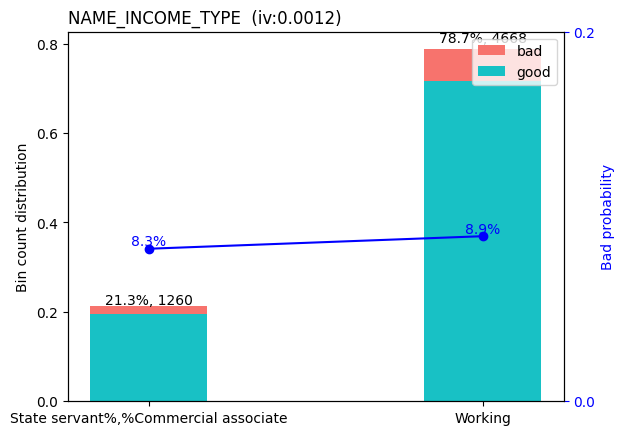

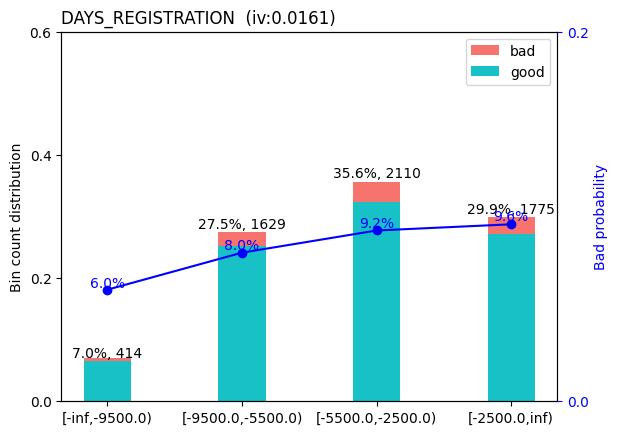

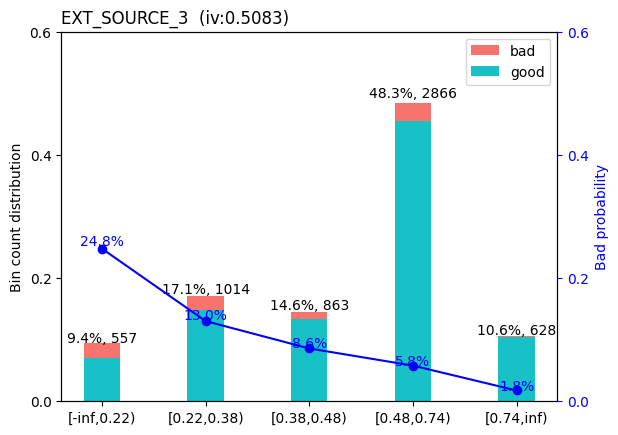

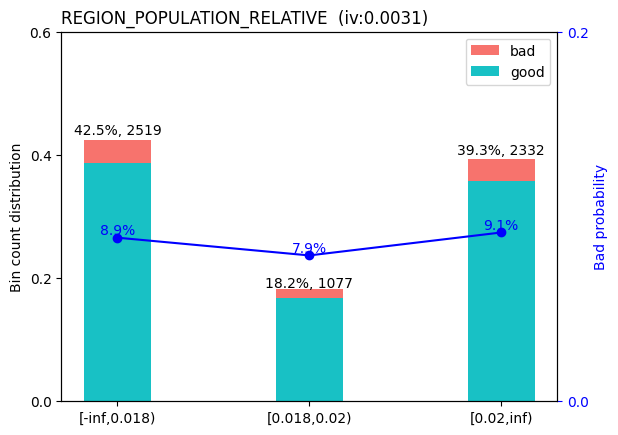

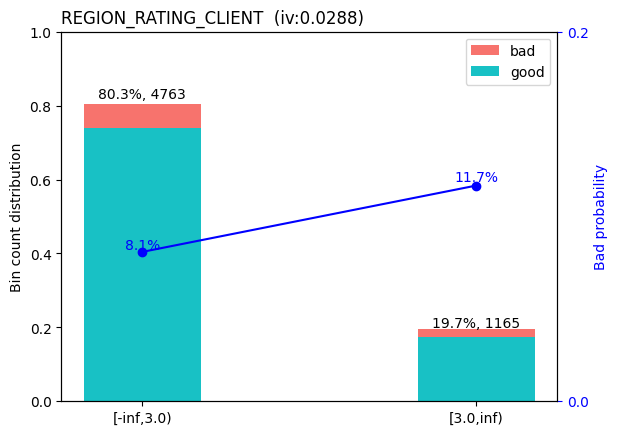

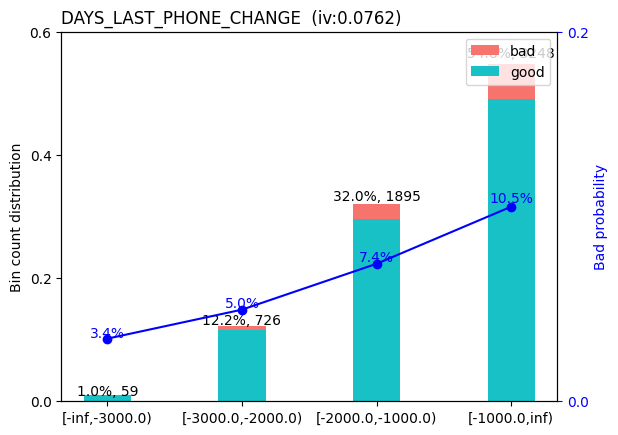

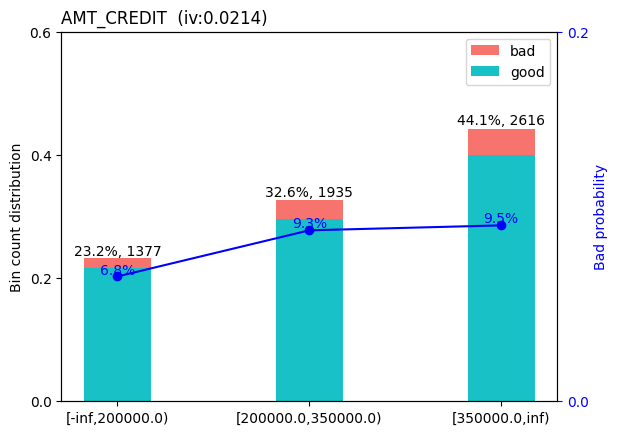

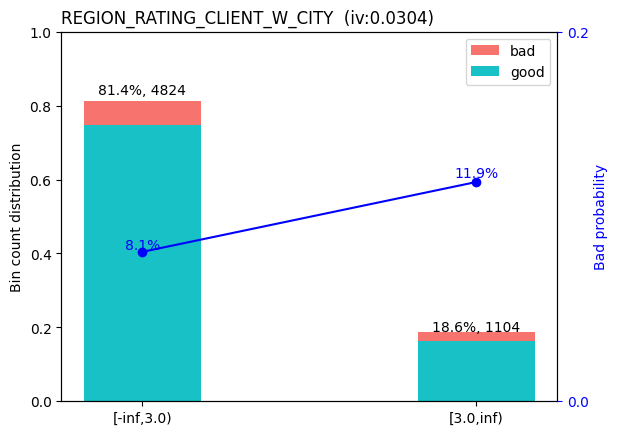

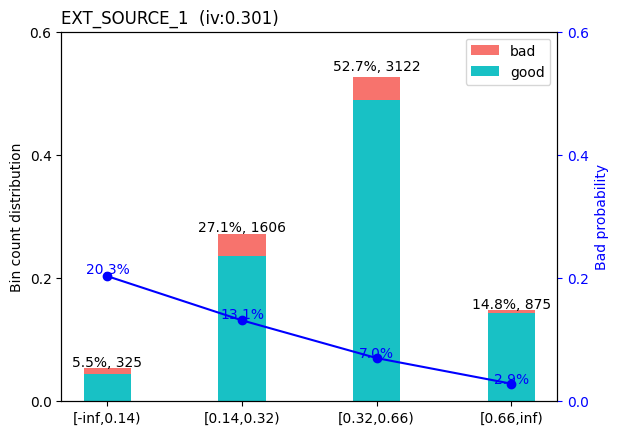

In [45]:
# summary of adjustment for manual binning to display monotonicity

breaks_adj = {
    'AMT_GOODS_PRICE' : [14000,200000, 300000],
    'REGION_POPULATION_RELATIVE' : [0.018 ,0.02],
    'AMT_INCOME_TOTAL' : [60000,80000,100000],
    'DAYS_LAST_PHONE_CHANGE' : [-3000,-2000,-1000],
    'DAYS_REGISTRATION' : [-9500.0,-5500.0,-2500.0],
    'AMT_CREDIT' : [200000,350000],
    'AMT_ANNUITY' : [10000,22000],
    'REGION_POPULATION_RELATIVE' : [0.018 ,0.02]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2)

In [46]:
# Inspecting the IV value adrer manual binning adjustment for monotonicity

iv_data=[]
for variables , bindetails in bins2.items():
    iv_data.append({'variable': variables, 'iv': round(bindetails['total_iv'][0], 6)})
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,34.0)",2109,0.355769,1856,253,0.119962,0.346910,0.049381,0.126176,34.0,False
1,AGE,"[34.0,37.0)",651,0.109818,586,65,0.099846,0.140767,0.002306,0.126176,37.0,False
2,AGE,"[37.0,48.0)",2126,0.358637,1972,154,0.072437,-0.210151,0.014527,0.126176,48.0,False
3,AGE,"[48.0,inf)",1042,0.175776,993,49,0.047025,-0.669211,0.059962,0.126176,inf,False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,"[-inf,200000.0)",1543,0.260290,1426,117,0.075826,-0.160755,0.006296,0.009058,200000.0,False
1,AMT_GOODS_PRICE,"[200000.0,300000.0)",1721,0.290317,1568,153,0.088902,0.012581,0.000046,0.009058,300000.0,False
2,AMT_GOODS_PRICE,"[300000.0,inf)",2664,0.449393,2413,251,0.094219,0.076527,0.002716,0.009058,inf,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,4.0)",2523,0.425607,2258,265,0.105034,0.197195,0.017951,0.056935,4.0,False
1,YEARS_EMPLOYED,"[4.0,6.0)",1008,0.170040,915,93,0.092262,0.053375,0.000495,0.056935,6.0,False
2,YEARS_EMPLOYED,"[6.0,10.0)",1267,0.213731,1168,99,0.078137,-0.128229,0.003334,0.056935,10.0,False
3,YEARS_EMPLOYED,"[10.0,inf)",1130,0.190621,1066,64,0.056637,-0.473086,0.035156,0.056935,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,10000.0)",882,0.148785,826,56,0.063492,-0.351543,0.015918,0.026124,10000.0,False
1,AMT_ANNUITY,"[10000.0,22000.0)",2918,0.492240,2669,249,0.085332,-0.032307,0.000507,0.026124,22000.0,False
2,AMT_ANNUITY,"[22000.0,inf)",2128,0.358974,1912,216,0.101504,0.159073,0.009699,0.026124,inf,False


----------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_INCOME_TOTAL,"[-inf,60000.0)",291,0.049089,273,18,0.061856,-0.379400,0.006048,0.010089,60000.0,False
1,AMT_INCOME_TOTAL,"[60000.0,80000.0)",978,0.164980,899,79,0.080777,-0.092136,0.001348,0.010089,80000.0,False
2,AMT_INCOME_TOTAL,"[80000.0,100000.0)",2303,0.388495,2085,218,0.094659,0.081671,0.002680,0.010089,100000.0,False
3,AMT_INCOME_TOTAL,"[100000.0,inf)",2356,0.397436,2150,206,0.087436,-0.005647,0.000013,0.010089,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_2,"[-inf,0.26)",856,0.144399,705,151,0.176402,0.798782,0.127358,0.246114,0.26,False
1,EXT_SOURCE_2,"[0.26,0.4)",924,0.155870,816,108,0.116883,0.317417,0.017895,0.246114,0.4,False
2,EXT_SOURCE_2,"[0.4,0.66)",3053,0.515013,2840,213,0.069767,-0.250568,0.029170,0.246114,0.66,False
3,EXT_SOURCE_2,"[0.66,inf)",1095,0.184717,1046,49,0.044749,-0.721209,0.071690,0.246114,inf,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"State servant%,%Commercial associate",1260,0.212551,1156,104,0.082540,-0.068631,0.000973,0.001227,"State servant%,%Commercial associate",False
1,NAME_INCOME_TYPE,Working,4668,0.787449,4251,417,0.089332,0.017876,0.000254,0.001227,Working,False


----------------------------------------------------------------------------------------------------
DAYS_REGISTRATION  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_REGISTRATION,"[-inf,-9500.0)",414,0.069838,389,25,0.060386,-0.405004,0.009704,0.016085,-9500.0,False
1,DAYS_REGISTRATION,"[-9500.0,-5500.0)",1629,0.274798,1498,131,0.080417,-0.096989,0.002484,0.016085,-5500.0,False
2,DAYS_REGISTRATION,"[-5500.0,-2500.0)",2110,0.355938,1915,195,0.092417,0.055226,0.001111,0.016085,-2500.0,False
3,DAYS_REGISTRATION,"[-2500.0,inf)",1775,0.299426,1605,170,0.095775,0.094619,0.002787,0.016085,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_3  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_3,"[-inf,0.22)",557,0.093961,419,138,0.247756,1.229082,0.230309,0.508267,0.22,False
1,EXT_SOURCE_3,"[0.22,0.38)",1014,0.171053,882,132,0.130178,0.440310,0.039732,0.508267,0.38,False
2,EXT_SOURCE_3,"[0.38,0.48)",863,0.145580,789,74,0.085747,-0.027002,0.000105,0.508267,0.48,False
3,EXT_SOURCE_3,"[0.48,0.74)",2866,0.483468,2700,166,0.057920,-0.449320,0.081208,0.508267,0.74,False
4,EXT_SOURCE_3,"[0.74,inf)",628,0.105938,617,11,0.017516,-1.687274,0.156913,0.508267,inf,False


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.018)",2519,0.424933,2296,223,0.088527,0.007948,0.000027,0.003128,0.018,False
1,REGION_POPULATION_RELATIVE,"[0.018,0.02)",1077,0.181680,992,85,0.078923,-0.117372,0.002385,0.003128,0.02,False
2,REGION_POPULATION_RELATIVE,"[0.02,inf)",2332,0.393387,2119,213,0.091338,0.042292,0.000716,0.003128,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT,"[-inf,3.0)",4763,0.803475,4378,385,0.080831,-0.091404,0.006465,0.028816,3.0,False
1,REGION_RATING_CLIENT,"[3.0,inf)",1165,0.196525,1029,136,0.116738,0.316012,0.022351,0.028816,inf,False


----------------------------------------------------------------------------------------------------
DAYS_LAST_PHONE_CHANGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_LAST_PHONE_CHANGE,"[-inf,-3000.0)",59,0.009953,57,2,0.033898,-1.010204,0.006772,0.076203,-3000.0,False
1,DAYS_LAST_PHONE_CHANGE,"[-3000.0,-2000.0)",726,0.122470,690,36,0.049587,-0.613473,0.035897,0.076203,-2000.0,False
2,DAYS_LAST_PHONE_CHANGE,"[-2000.0,-1000.0)",1895,0.319669,1754,141,0.074406,-0.181195,0.009741,0.076203,-1000.0,False
3,DAYS_LAST_PHONE_CHANGE,"[-1000.0,inf)",3248,0.547908,2906,342,0.105296,0.199978,0.023793,0.076203,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,200000.0)",1377,0.232287,1284,93,0.067538,-0.285436,0.016831,0.021415,200000.0,False
1,AMT_CREDIT,"[200000.0,350000.0)",1935,0.326417,1756,179,0.092506,0.056292,0.001059,0.021415,350000.0,False
2,AMT_CREDIT,"[350000.0,inf)",2616,0.441296,2367,249,0.095183,0.087774,0.003525,0.021415,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,3.0)",4824,0.813765,4434,390,0.080846,-0.091211,0.006520,0.030434,3.0,False
1,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",1104,0.186235,973,131,0.118659,0.334513,0.023914,0.030434,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_1,"[-inf,0.14)",325,0.054825,259,66,0.203077,0.972526,0.076614,0.301023,0.14,False
1,EXT_SOURCE_1,"[0.14,0.32)",1606,0.270918,1395,211,0.131382,0.450908,0.066280,0.301023,0.32,False
2,EXT_SOURCE_1,"[0.32,0.66)",3122,0.526653,2903,219,0.070147,-0.244729,0.028523,0.301023,0.66,False
3,EXT_SOURCE_1,"[0.66,inf)",875,0.147605,850,25,0.028571,-1.186661,0.129606,0.301023,inf,False


----------------------------------------------------------------------------------------------------


In [106]:
# calculate total IV for each variable
iv_df3 = pd.DataFrame(columns=['Variable', 'Variable IV'])
for variables, bindetails in bins3.items():
    variables_iv = bindetails.loc[0,'total_iv']
    iv_df3 = iv_df3.append({'Variable': variables, 'Variable IV': variables_iv}, ignore_index=True)

# sort IV dataframe by Total IV in descending order
iv_df3 = iv_df3.sort_values(by='Variable IV', ascending=False,ignore_index=True)

# display sorted IV dataframe
print(iv_df3)

                       Variable  Variable IV
0                  EXT_SOURCE_3     0.508267
1                  EXT_SOURCE_1     0.301023
2                  EXT_SOURCE_2     0.246114
3                           AGE     0.126176
4        DAYS_LAST_PHONE_CHANGE     0.094473
5               AMT_GOODS_PRICE     0.072548
6                    AMT_CREDIT     0.071174
7                YEARS_EMPLOYED     0.056935
8    REGION_POPULATION_RELATIVE     0.054699
9                   AMT_ANNUITY     0.054608
10            DAYS_REGISTRATION     0.031676
11  REGION_RATING_CLIENT_W_CITY     0.030434
12         REGION_RATING_CLIENT     0.028816
13             AMT_INCOME_TOTAL     0.021572
14             NAME_INCOME_TYPE     0.001227


## Prepare Training and Test Data for Logistic Regression

In [107]:
# split for 0.7 training data and 0.3 testing data
train, test = sc.split_df(final_customer_loan_data, 'STATUS', ratio=0.7).values()

In [166]:
train_woe = sc.woebin_ply(train, bins2)
test_woe = sc.woebin_ply(test, bins2)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


## Training Logistic Regression Model

In [109]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'STATUS']
X_train = train_woe.loc[:,train_woe.columns != 'STATUS']
y_test = test_woe.loc[:,'STATUS']
X_test = test_woe.loc[:,train_woe.columns != 'STATUS']

#create a logistic regression model object
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[-0.05774298 -0.35589557  0.1879136   1.21289568  0.20776034  0.84668568
   0.09593171  0.83626891  0.38984381 -0.38562529  0.45086467  0.66884388
   0.47493104 -0.3111497   0.6888739 ]]
[-2.33196536]


# <h3>Balancing the class weight for Logistic Regression</h3>
Balance out the class distribution in the training data and reduce the risk of the model being biased towards the majority class.

In [110]:
#dict parameter for class weights
lr_bal2=LogisticRegression(random_state=42,class_weight={0: 0.2,1: 0.8})
lr_bal2.fit(X_train,y_train)
print(lr.coef_)
print(lr.intercept_)

[[-0.05774298 -0.35589557  0.1879136   1.21289568  0.20776034  0.84668568
   0.09593171  0.83626891  0.38984381 -0.38562529  0.45086467  0.66884388
   0.47493104 -0.3111497   0.6888739 ]]
[-2.33196536]


In [111]:
from sklearn.utils import class_weight
sklearn_weights1 = class_weight.compute_class_weight(class_weight=None, y=final_customer_loan_data['STATUS'], classes=np.unique(final_customer_loan_data['STATUS']))
sklearn_weights1


array([1., 1.])

In [112]:
# Compare the values between training and testing datasets
print(f'The weights for the majority class is {sklearn_weights1[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights1[1]*2:.3f}')


The weights for the majority class is 2.000
The weights for the minority class is 2.000


In [113]:
from sklearn.utils import class_weight
sklearn_weights2 = class_weight.compute_class_weight(class_weight='balanced', y=final_customer_loan_data['STATUS'], classes=np.unique(final_customer_loan_data['STATUS']))
sklearn_weights2


array([0.54817829, 5.6890595 ])

In [150]:
# Compare the values of the weights for majority and minority classes
print(f'The weights for the majority class is {sklearn_weights2[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights2[1]*2:.3f}')

The weights for the majority class is 1.096
The weights for the minority class is 11.378


In [115]:
from sklearn.utils import class_weight

dict1 = {0: 0.2, 1: 0.8}
sklearn_weights3 = class_weight.compute_class_weight(class_weight=dict1, y=final_customer_loan_data['STATUS'], classes=np.unique(final_customer_loan_data['STATUS']))
sklearn_weights3

array([0.2, 0.8])

In [116]:
print(f'The weights for the majority class is {sklearn_weights3[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights3[1]*2:.3f}')

The weights for the majority class is 0.400
The weights for the minority class is 1.600


### -- End of Weightage Balancing --

# Generating scorecard 

Use sc.scorecard to generate the scorecard

In [117]:
#generate a card from the model and bins. The scores will be based on probability of default from the model
card = sc.scorecard(bins2, lr_bal2, X_train.columns, 
                    points0 = 600, 
                    odds0 = 1/50, 
                    pdo = 20,
      basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':   variable          bin  points
0      AGE  [-inf,34.0)    34.0
1      AGE  [34.0,37.0)    34.0
2      AGE  [37.0,48.0)    34.0
3      AGE   [48.0,inf)    34.0,
 'AMT_ANNUITY':        variable                bin  points
11  AMT_ANNUITY     [-inf,10000.0)    46.0
12  AMT_ANNUITY  [10000.0,22000.0)    35.0
13  AMT_ANNUITY      [22000.0,inf)    29.0,
 'AMT_CREDIT':       variable                  bin  points
42  AMT_CREDIT      [-inf,200000.0)    38.0
43  AMT_CREDIT  [200000.0,350000.0)    33.0
44  AMT_CREDIT       [350000.0,inf)    33.0,
 'AMT_GOODS_PRICE':           variable                  bin  points
4  AMT_GOODS_PRICE      [-inf,200000.0)    34.0
5  AMT_GOODS_PRICE  [200000.0,300000.0)    34.0
6  AMT_GOODS_PRICE       [300000.0,inf)    35.0,
 'AMT_INCOME_TOTAL':             variable                 bin  points
14  AMT_INCOME_TOTAL      [-inf,60000.0)    35.0
15  AMT_INCOME_TOTAL   [60000.0,80000.0)    34.0
16  AMT_INCOME_TOTAL  [80000.0,100000.0)    34.0
17  AMT_INCOME_TOTAL

In [118]:
# make it easy to read the bins
for variables , bindetails in card.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

basepoints  : 


,variable,bin,points
0,basepoints,NaN,0


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,points
0,AGE,"[-inf,34.0)",34.0
1,AGE,"[34.0,37.0)",34.0
2,AGE,"[37.0,48.0)",34.0
3,AGE,"[48.0,inf)",34.0


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,points
4,AMT_GOODS_PRICE,"[-inf,200000.0)",34.0
5,AMT_GOODS_PRICE,"[200000.0,300000.0)",34.0
6,AMT_GOODS_PRICE,"[300000.0,inf)",35.0


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,points
7,YEARS_EMPLOYED,"[-inf,4.0)",33.0
8,YEARS_EMPLOYED,"[4.0,6.0)",34.0
9,YEARS_EMPLOYED,"[6.0,10.0)",35.0
10,YEARS_EMPLOYED,"[10.0,inf)",37.0


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,points
11,AMT_ANNUITY,"[-inf,10000.0)",46.0
12,AMT_ANNUITY,"[10000.0,22000.0)",35.0
13,AMT_ANNUITY,"[22000.0,inf)",29.0


----------------------------------------------------------------------------------------------------
DAYS_REGISTRATION  : 


,variable,bin,points
24,DAYS_REGISTRATION,"[-inf,-9500.0)",36.0
25,DAYS_REGISTRATION,"[-9500.0,-5500.0)",35.0
26,DAYS_REGISTRATION,"[-5500.0,-2500.0)",34.0
27,DAYS_REGISTRATION,"[-2500.0,inf)",34.0


----------------------------------------------------------------------------------------------------
EXT_SOURCE_3  : 


,variable,bin,points
28,EXT_SOURCE_3,"[-inf,0.22)",4.0
29,EXT_SOURCE_3,"[0.22,0.38)",24.0
30,EXT_SOURCE_3,"[0.38,0.48)",35.0
31,EXT_SOURCE_3,"[0.48,0.74)",45.0
32,EXT_SOURCE_3,"[0.74,inf)",76.0


----------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL  : 


,variable,bin,points
14,AMT_INCOME_TOTAL,"[-inf,60000.0)",35.0
15,AMT_INCOME_TOTAL,"[60000.0,80000.0)",34.0
16,AMT_INCOME_TOTAL,"[80000.0,100000.0)",34.0
17,AMT_INCOME_TOTAL,"[100000.0,inf)",34.0


----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


,variable,bin,points
18,EXT_SOURCE_2,"[-inf,0.26)",15.0
19,EXT_SOURCE_2,"[0.26,0.4)",27.0
20,EXT_SOURCE_2,"[0.4,0.66)",40.0
21,EXT_SOURCE_2,"[0.66,inf)",52.0


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,points
33,REGION_POPULATION_RELATIVE,"[-inf,0.018)",34.0
34,REGION_POPULATION_RELATIVE,"[0.018,0.02)",35.0
35,REGION_POPULATION_RELATIVE,"[0.02,inf)",34.0


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT  : 


,variable,bin,points
36,REGION_RATING_CLIENT,"[-inf,3.0)",34.0
37,REGION_RATING_CLIENT,"[3.0,inf)",36.0


----------------------------------------------------------------------------------------------------
DAYS_LAST_PHONE_CHANGE  : 


,variable,bin,points
38,DAYS_LAST_PHONE_CHANGE,"[-inf,-3000.0)",48.0
39,DAYS_LAST_PHONE_CHANGE,"[-3000.0,-2000.0)",43.0
40,DAYS_LAST_PHONE_CHANGE,"[-2000.0,-1000.0)",37.0
41,DAYS_LAST_PHONE_CHANGE,"[-1000.0,inf)",32.0


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,points
42,AMT_CREDIT,"[-inf,200000.0)",38.0
43,AMT_CREDIT,"[200000.0,350000.0)",33.0
44,AMT_CREDIT,"[350000.0,inf)",33.0


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,points
45,REGION_RATING_CLIENT_W_CITY,"[-inf,3.0)",35.0
46,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",31.0


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,points
22,NAME_INCOME_TYPE,"State servant%,%Commercial associate",34.0
23,NAME_INCOME_TYPE,Working,34.0


----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


,variable,bin,points
47,EXT_SOURCE_1,"[-inf,0.14)",15.0
48,EXT_SOURCE_1,"[0.14,0.32)",25.0
49,EXT_SOURCE_1,"[0.32,0.66)",39.0
50,EXT_SOURCE_1,"[0.66,inf)",58.0


----------------------------------------------------------------------------------------------------


# Examining and Evaluating the test and train data + Scorecard Scaling

Use sc.scorecard_ply to score all the test and train data and examine the distribution of the scores

In [119]:
# helper function to format scorecard
def concatScorecard(card):
    scorecard = pd.DataFrame()

    for key in card.keys() :
        if key == "basepoints" or key == "purpose":
            continue
        if scorecard.empty:
            scorecard = card[key]
        else:
            scorecard = pd.concat([scorecard, card[key]], axis=0)
    return scorecard.set_index('variable', append = True).swaplevel(0,1)

In [120]:
# show the scorecard in a table
pd.set_option('display.max_rows', None)

scorecard = concatScorecard(card)
scorecard

bin  points
variable                                                                    
AGE                         0                            [-inf,34.0)    34.0
                            1                            [34.0,37.0)    34.0
                            2                            [37.0,48.0)    34.0
                            3                             [48.0,inf)    34.0
AMT_GOODS_PRICE             4                        [-inf,200000.0)    34.0
                            5                    [200000.0,300000.0)    34.0
                            6                         [300000.0,inf)    35.0
YEARS_EMPLOYED              7                             [-inf,4.0)    33.0
                            8                              [4.0,6.0)    34.0
                            9                             [6.0,10.0)    35.0
                            10                            [10.0,inf)    37.0
AMT_ANNUITY                 11                        [-inf,10000.0)    46.0
                            12                     [10000.0,22000.0)    35.0
                            13                         [22000.0,inf)    29.0
DAYS_REGISTRATION           24                        [-inf,-9500.0)    36.0
                            25                     [-9500.0,-5500.0)    35.0
                            26                     [-5500.0,-2500.0)    34.0
                            27                         [-2500.0,inf)    34.0
EXT_SOURCE_3                28                           [-inf,0.22)     4.0
                            29                           [0.22,0.38)    24.0
                            30                           [0.38,0.48)    35.0
                            31                           [0.48,0.74)    45.0
                            32                            [0.74,inf)    76.0
AMT_INCOME_TOTAL            14                        [-inf,60000.0)    35.0
                            15                     [60000.0,80000.0)    34.0
                            16                    [80000.0,100000.0)    34.0
                            17                        [100000.0,inf)    34.0
EXT_SOURCE_2                18                           [-inf,0.26)    15.0
                            19                            [0.26,0.4)    27.0
                            20                            [0.4,0.66)    40.0
                            21                            [0.66,inf)    52.0
REGION_POPULATION_RELATIVE  33                          [-inf,0.018)    34.0
                            34                          [0.018,0.02)    35.0
                            35                            [0.02,inf)    34.0
REGION_RATING_CLIENT        36                            [-inf,3.0)    34.0
                            37                             [3.0,inf)    36.0
DAYS_LAST_PHONE_CHANGE      38                        [-inf,-3000.0)    48.0
                            39                     [-3000.0,-2000.0)    43.0
                            40                     [-2000.0,-1000.0)    37.0
                            41                         [-1000.0,inf)    32.0
AMT_CREDIT                  42                       [-inf,200000.0)    38.0
                            43                   [200000.0,350000.0)    33.0
                            44                        [350000.0,inf)    33.0
REGION_RATING_CLIENT_W_CITY 45                            [-inf,3.0)    35.0
                            46                             [3.0,inf)    31.0
NAME_INCOME_TYPE            22  State servant%,%Commercial associate    34.0
                            23                               Working    34.0
EXT_SOURCE_1                47                           [-inf,0.14)    15.0
                            48                           [0.14,0.32)    25.0
                            49                           [0.32,0.66)    39.0
                            50                            [0.

In [121]:
# Getting base points for the scorecard 
card_basepoint = sc.scorecard(bins2, lr_bal2, X_train.columns, 
                    points0 = 600, 
                    odds0 = 1/50, 
                    pdo = 20,
      basepoints_eq0 = True)
scorecard_basepoint = concatScorecard(card_basepoint)

print(card_basepoint['basepoints'])
scorecard_basepoint

     variable  bin  points
0  basepoints  NaN       0


bin  points
variable                                                                    
AGE                         0                            [-inf,34.0)    34.0
                            1                            [34.0,37.0)    34.0
                            2                            [37.0,48.0)    34.0
                            3                             [48.0,inf)    34.0
AMT_GOODS_PRICE             4                        [-inf,200000.0)    34.0
                            5                    [200000.0,300000.0)    34.0
                            6                         [300000.0,inf)    35.0
YEARS_EMPLOYED              7                             [-inf,4.0)    33.0
                            8                              [4.0,6.0)    34.0
                            9                             [6.0,10.0)    35.0
                            10                            [10.0,inf)    37.0
AMT_ANNUITY                 11                        [-inf,10000.0)    46.0
                            12                     [10000.0,22000.0)    35.0
                            13                         [22000.0,inf)    29.0
DAYS_REGISTRATION           24                        [-inf,-9500.0)    36.0
                            25                     [-9500.0,-5500.0)    35.0
                            26                     [-5500.0,-2500.0)    34.0
                            27                         [-2500.0,inf)    34.0
EXT_SOURCE_3                28                           [-inf,0.22)     4.0
                            29                           [0.22,0.38)    24.0
                            30                           [0.38,0.48)    35.0
                            31                           [0.48,0.74)    45.0
                            32                            [0.74,inf)    76.0
AMT_INCOME_TOTAL            14                        [-inf,60000.0)    35.0
                            15                     [60000.0,80000.0)    34.0
                            16                    [80000.0,100000.0)    34.0
                            17                        [100000.0,inf)    34.0
EXT_SOURCE_2                18                           [-inf,0.26)    15.0
                            19                            [0.26,0.4)    27.0
                            20                            [0.4,0.66)    40.0
                            21                            [0.66,inf)    52.0
REGION_POPULATION_RELATIVE  33                          [-inf,0.018)    34.0
                            34                          [0.018,0.02)    35.0
                            35                            [0.02,inf)    34.0
REGION_RATING_CLIENT        36                            [-inf,3.0)    34.0
                            37                             [3.0,inf)    36.0
DAYS_LAST_PHONE_CHANGE      38                        [-inf,-3000.0)    48.0
                            39                     [-3000.0,-2000.0)    43.0
                            40                     [-2000.0,-1000.0)    37.0
                            41                         [-1000.0,inf)    32.0
AMT_CREDIT                  42                       [-inf,200000.0)    38.0
                            43                   [200000.0,350000.0)    33.0
                            44                        [350000.0,inf)    33.0
REGION_RATING_CLIENT_W_CITY 45                            [-inf,3.0)    35.0
                            46                             [3.0,inf)    31.0
NAME_INCOME_TYPE            22  State servant%,%Commercial associate    34.0
                            23                               Working    34.0
EXT_SOURCE_1                47                           [-inf,0.14)    15.0
                            48                           [0.14,0.32)    25.0
                            49                           [0.32,0.66)    39.0
                            50                            [0.

Text(0.5, 1.0, 'test data scores')

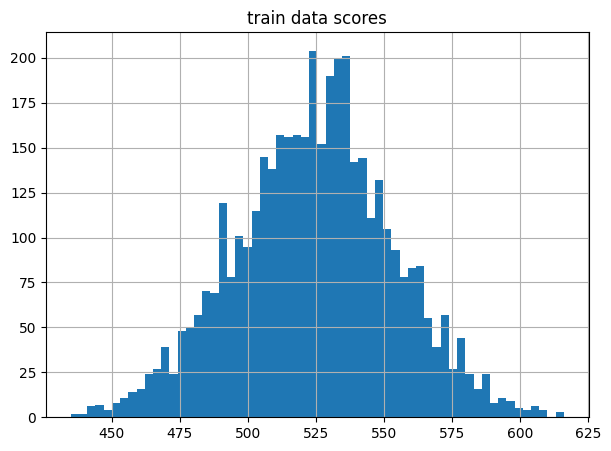

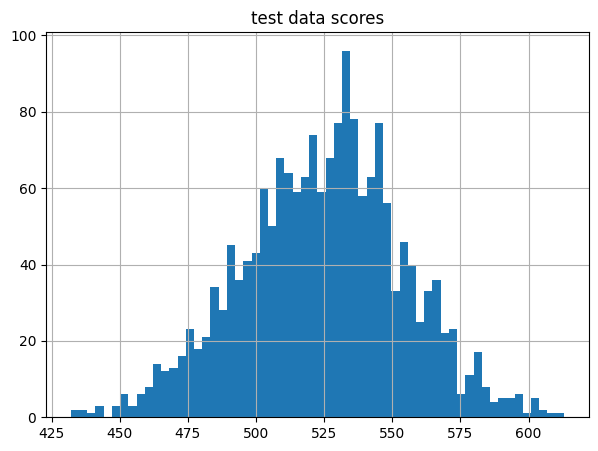

In [122]:
# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

**Calculate Percentage Correctly Classified measures on LR model**

In [123]:
# sample code
# print evaluation metrics of the model
y_pred = lr_bal2.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_pred, y_test))
print("\nPCC measures:")
print(classification_report(y_pred, y_test))

Confusion matrix:
[[1496   99]
 [ 126   57]]

PCC measures:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1595
           1       0.37      0.31      0.34       183

    accuracy                           0.87      1778
   macro avg       0.64      0.62      0.63      1778
weighted avg       0.86      0.87      0.87      1778



**Evaluate the performance of logistic regression model with ROC**

Generate the ROC and calculate the AUC for the model using the scorecardpy methods. 

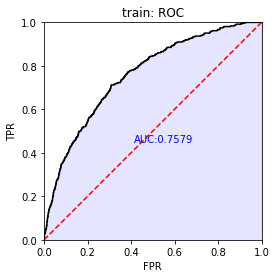

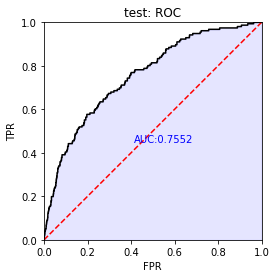

In [95]:
# # sample code 

# evaluate the performance of the logistic regression
train_pred = lr_bal2.predict_proba(X_train)[:,1]
test_pred = lr_bal2.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

In [124]:
# Sample data to test the scorecard

# calulate credit score for new application
col = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AGE', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'AMT_ANNUITY',
                'DAYS_REGISTRATION','NAME_INCOME_TYPE','AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE']
val = [[0.729566691,0.555912083,0.0,-828,4.0,30.0,406597.5,351000,2.0,1.0,24700.5,-3648,0,'State servant',270000.0,]]
new_appl = pd.DataFrame(val, columns=col)

new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score=False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary =  pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value','Points']
print(summary)


                                 App Value  Points
EXT_SOURCE_3                      0.729567    45.0
EXT_SOURCE_2                      0.555912    40.0
EXT_SOURCE_1                           0.0    15.0
DAYS_LAST_PHONE_CHANGE                -828    32.0
YEARS_EMPLOYED                         4.0    34.0
AGE                                   30.0    34.0
AMT_CREDIT                        406597.5    33.0
AMT_GOODS_PRICE                     351000    35.0
REGION_RATING_CLIENT_W_CITY            2.0    35.0
REGION_RATING_CLIENT                   1.0    34.0
AMT_ANNUITY                        24700.5    29.0
DAYS_REGISTRATION                    -3648    34.0
NAME_INCOME_TYPE                         0     NaN
AMT_INCOME_TOTAL             State servant     NaN
REGION_POPULATION_RELATIVE        270000.0    34.0
score                                  NaN   434.0


In [105]:
# sample code

# calulate credit score for new application
col = ['EXT_SOURCE_3', 
'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AGE', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'AMT_ANNUITY',
                'DAYS_REGISTRATION','NAME_INCOME_TYPE','AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE']
val = [
    [0.7,
    0.555912083,
    0.8,
    -1870,
    10.0,
    40.0,
    551000,
    475000,
    2.0,
    1.0,
    34700.5,
    -2574,
    'Working',
    370000.0,
    1.0]]
new_appl = pd.DataFrame(val, columns=col)

new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score=False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary =  pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value','Points']
print(summary)


                            App Value  Points
EXT_SOURCE_3                      0.7    45.0
EXT_SOURCE_2                 0.555912    40.0
EXT_SOURCE_1                      0.8    58.0
DAYS_LAST_PHONE_CHANGE          -1870    37.0
YEARS_EMPLOYED                   10.0    37.0
AGE                              40.0    34.0
AMT_CREDIT                     551000    33.0
AMT_GOODS_PRICE                475000    35.0
REGION_RATING_CLIENT_W_CITY       2.0    35.0
REGION_RATING_CLIENT              1.0    34.0
AMT_ANNUITY                   34700.5    29.0
DAYS_REGISTRATION               -2574    34.0
NAME_INCOME_TYPE              Working    34.0
AMT_INCOME_TOTAL             370000.0    34.0
REGION_POPULATION_RELATIVE        1.0    34.0
score                             NaN   553.0


<h1>Removing 3 Characteristics because of low IVs<h1>

In [128]:
adj_keep_list =['STATUS','EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'AMT_ANNUITY',
                'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE']

#  if the column is not in the keep list, the columns will be dropped from the customer loan data
drop_list = [col for col in customer_loan_data.columns if col not in adj_keep_list]
final_customer_loan_data = customer_loan_data.drop(columns=drop_list,inplace=False)

In [129]:
final_customer_loan_data.columns


Index(['STATUS', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'DAYS_REGISTRATION',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [131]:
#Replacing the missing values with np.nan and drop na values from the final customer loan data

final_customer_loan_data.replace('Missing', np.nan, inplace=True)
final_customer_loan_data.dropna(subset=['STATUS','EXT_SOURCE_3', 'EXT_SOURCE_2', 
                'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 
                'AMT_ANNUITY','DAYS_REGISTRATION'], inplace=True)

In [132]:
# creating woe bin based on the 15 selected columns/ features 
bins3 = sc.woebin(final_customer_loan_data, y='STATUS')

[INFO] creating woe binning ...


In [133]:
# calculate total IV for each variable
iv_df2 = pd.DataFrame(columns=['Variable', 'Variable IV',])
for variables, bindetails in bins3.items():
    variables_iv = bindetails.loc[0,'total_iv']
    iv_df2 = iv_df2.append({'Variable': variables, 'Variable IV': variables_iv}, ignore_index=True)

# sort IV dataframe by Total IV in descending order
iv_df2 = iv_df2.sort_values(by='Variable IV', ascending=False,ignore_index=True)

# display sorted IV dataframe
print(iv_df2)

                       Variable  Variable IV
0                  EXT_SOURCE_3     0.508267
1                  EXT_SOURCE_1     0.301023
2                  EXT_SOURCE_2     0.246114
3        DAYS_LAST_PHONE_CHANGE     0.094473
4               AMT_GOODS_PRICE     0.072548
5                    AMT_CREDIT     0.071174
6                YEARS_EMPLOYED     0.056935
7    REGION_POPULATION_RELATIVE     0.054699
8                   AMT_ANNUITY     0.054608
9             DAYS_REGISTRATION     0.031676
10  REGION_RATING_CLIENT_W_CITY     0.030434
11         REGION_RATING_CLIENT     0.028816


{'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'DAYS_REGISTRATION': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>}

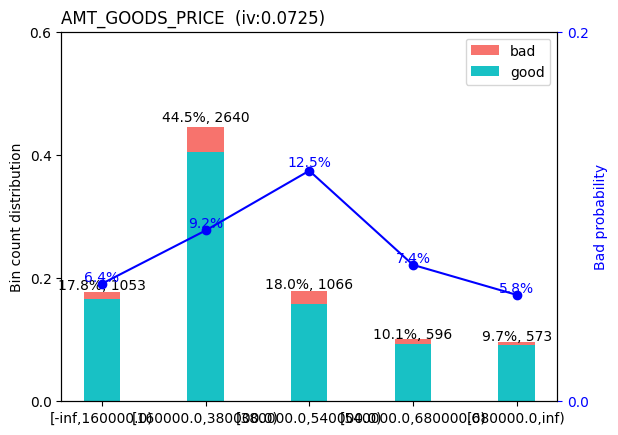

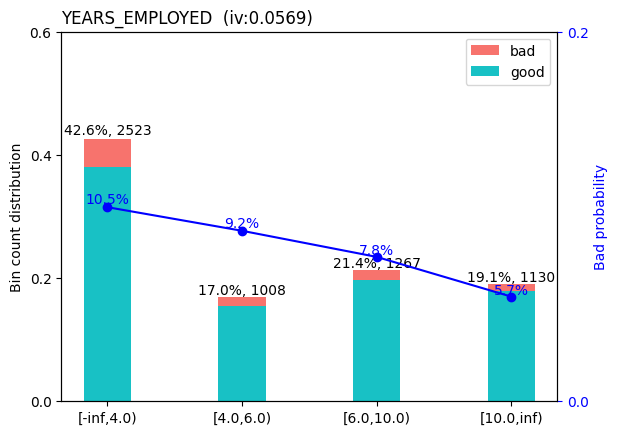

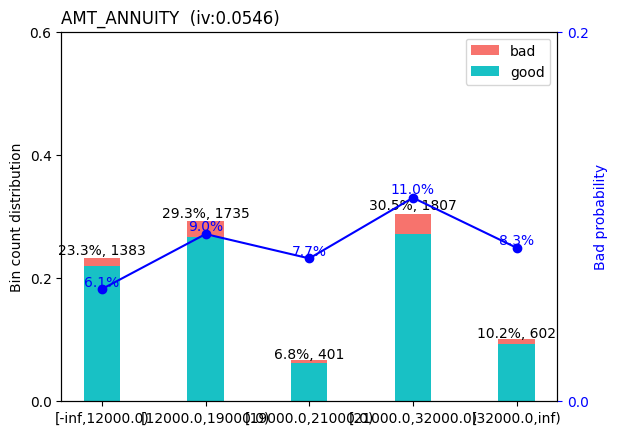

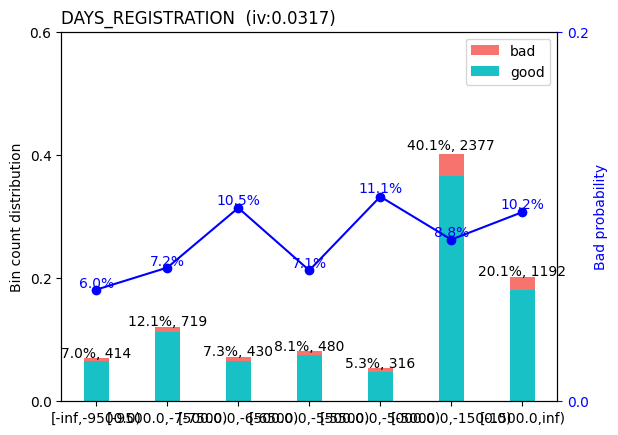

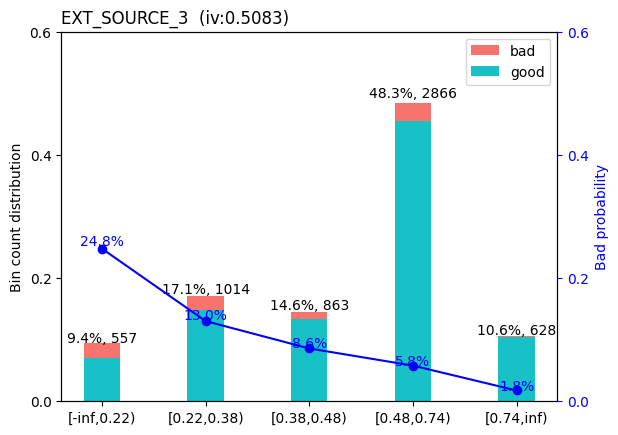

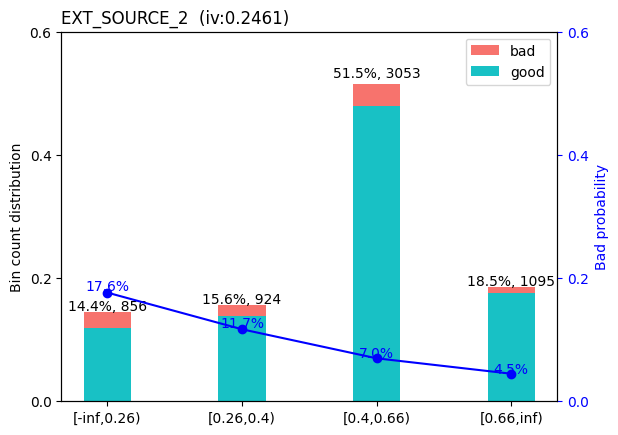

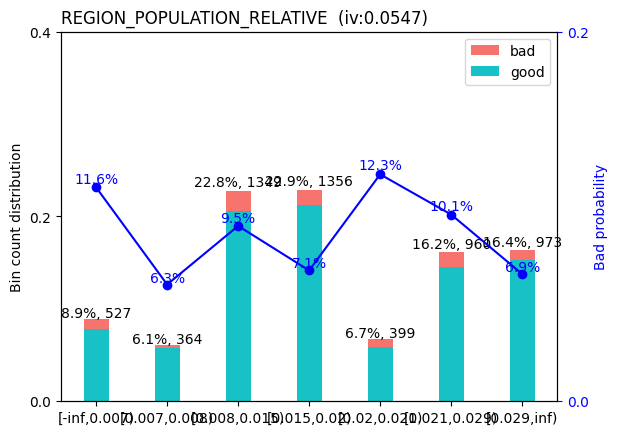

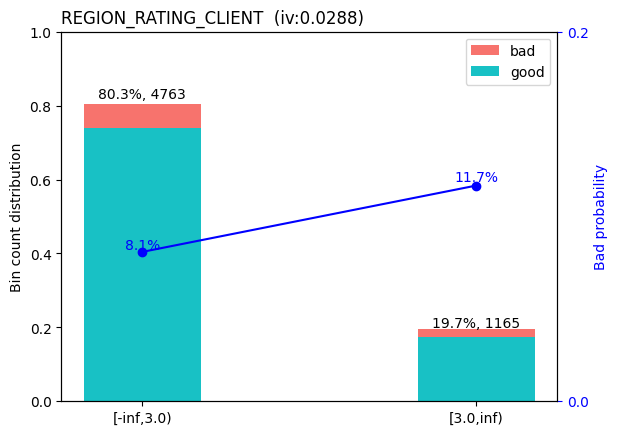

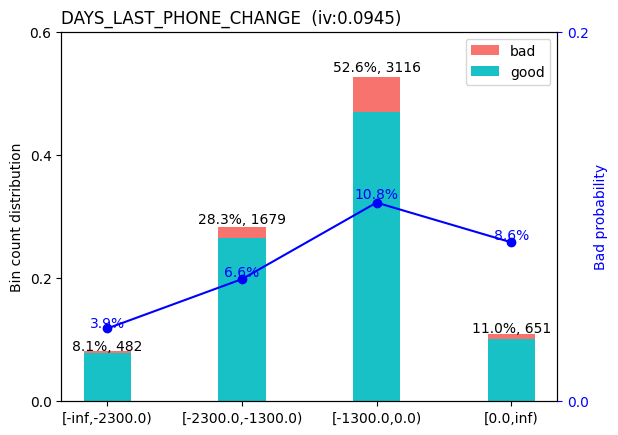

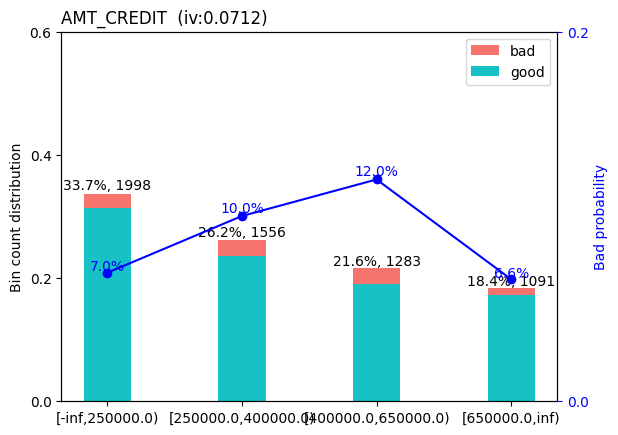

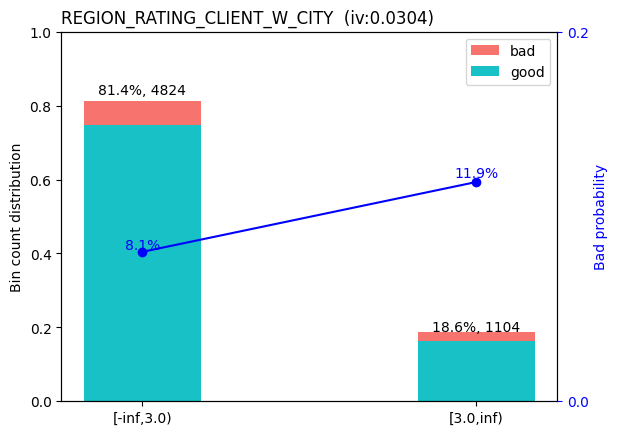

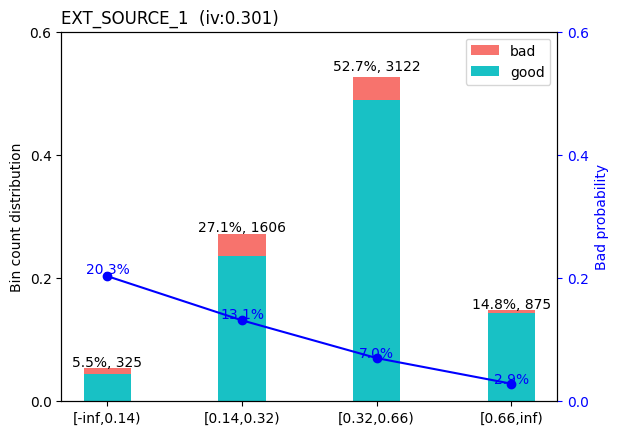

In [134]:
sc.woebin_plot(bins3)


[INFO] creating woe binning ...


{'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'DAYS_REGISTRATION': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>}

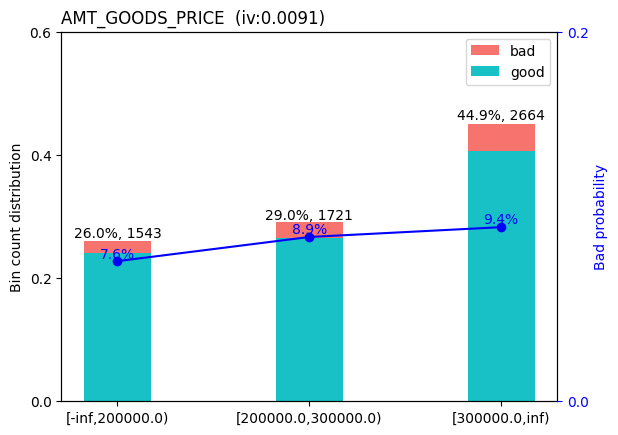

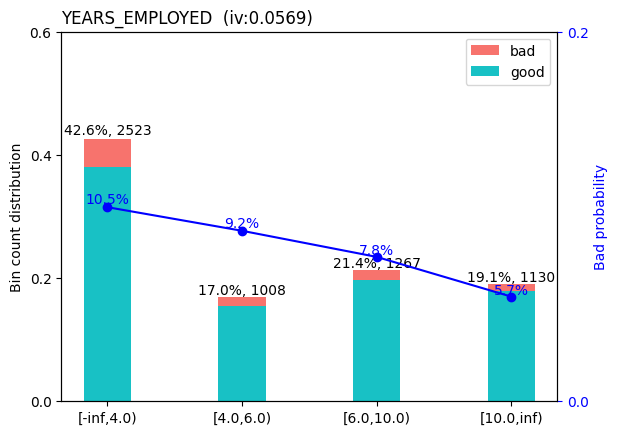

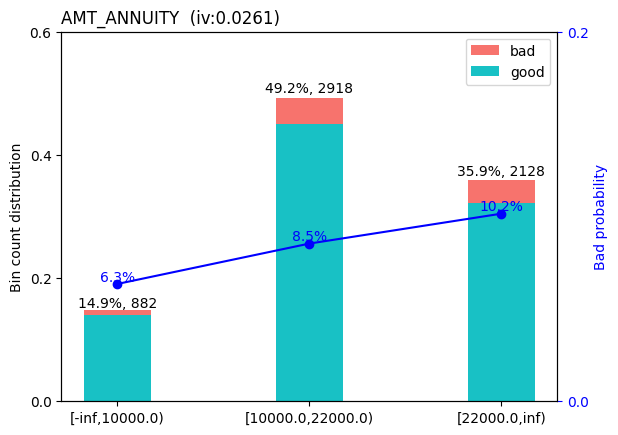

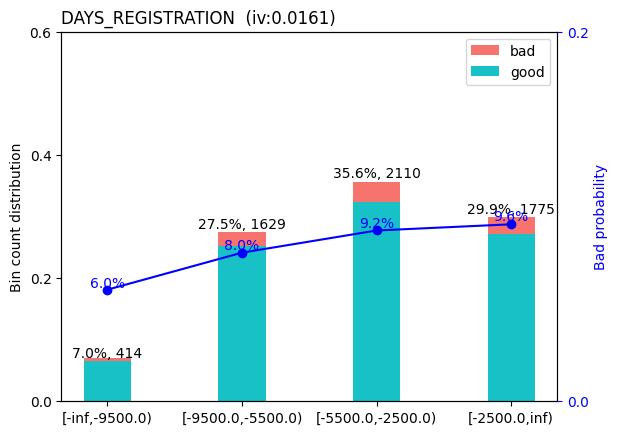

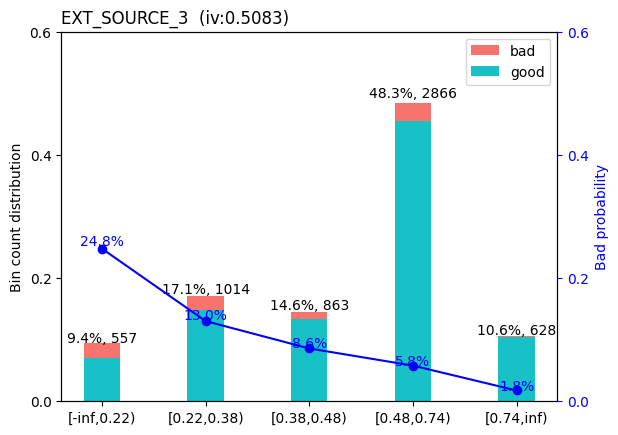

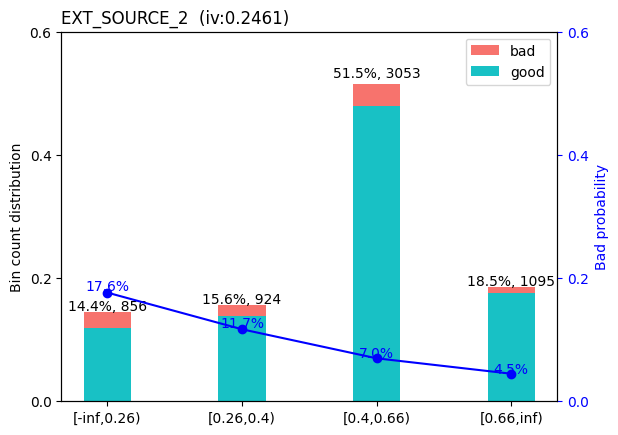

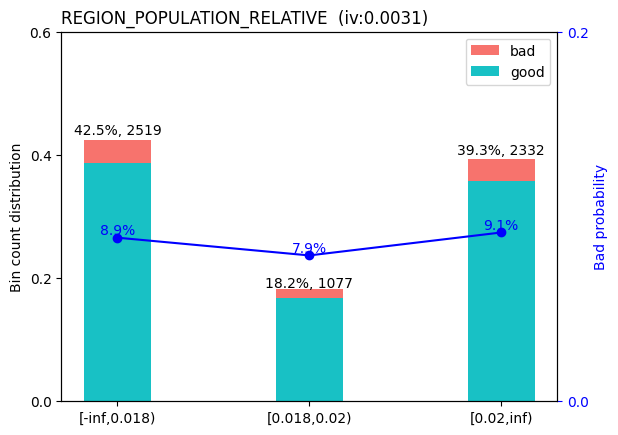

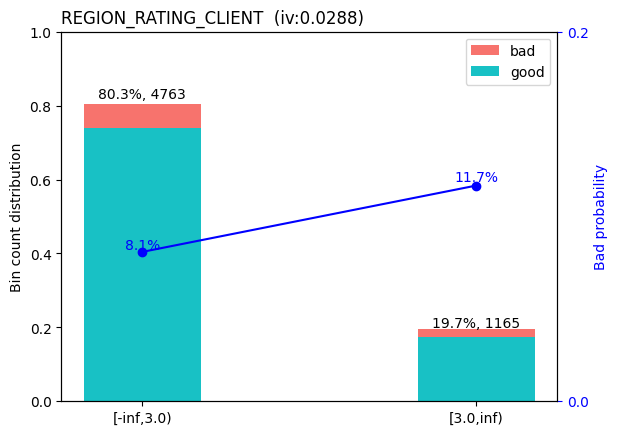

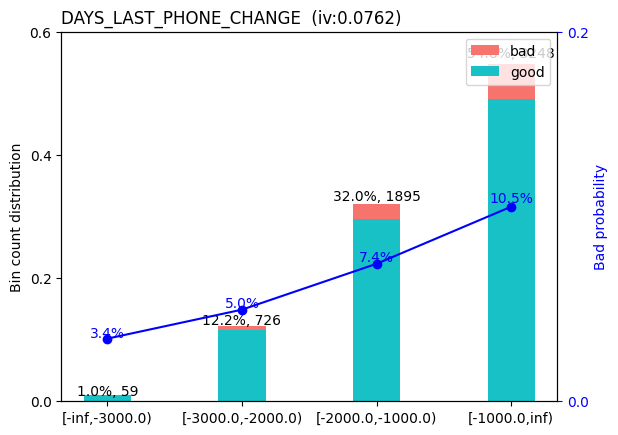

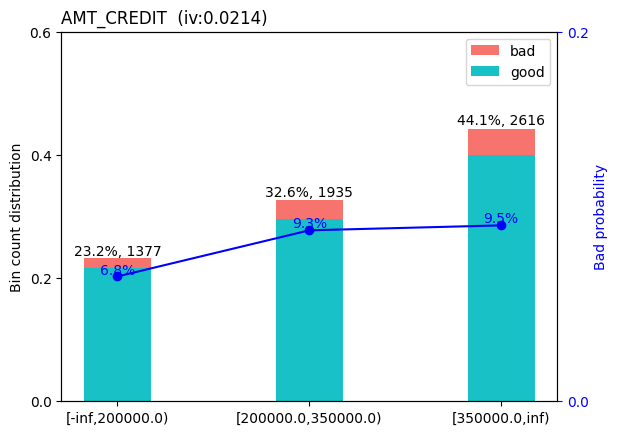

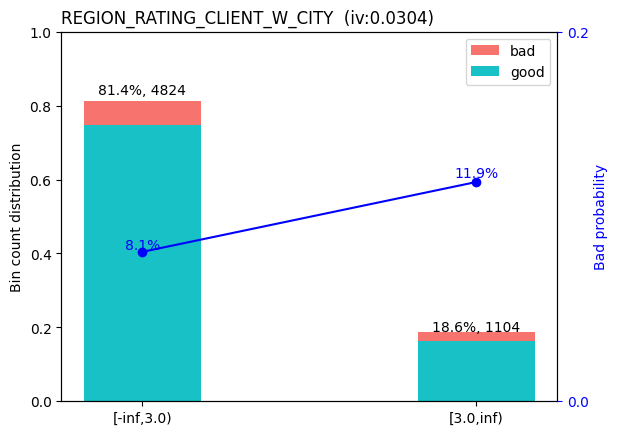

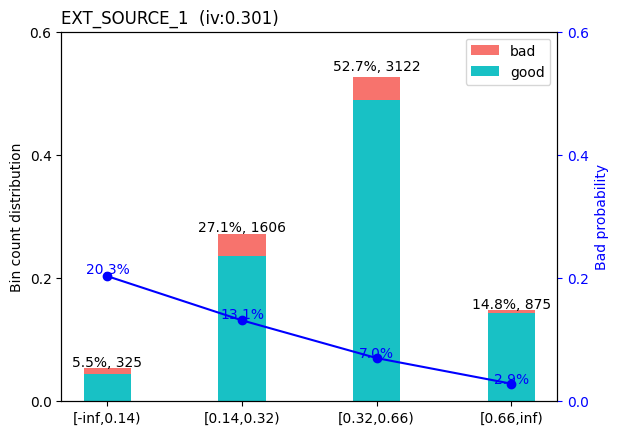

In [136]:
breaks_adj = {
    'AMT_GOODS_PRICE' : [14000,200000, 300000],
    'REGION_POPULATION_RELATIVE' : [0.018 ,0.02],
    'DAYS_LAST_PHONE_CHANGE' : [-3000,-2000,-1000],
    'DAYS_REGISTRATION' : [-9500.0,-5500.0,-2500.0],
    'AMT_CREDIT' : [200000,350000],
    'AMT_ANNUITY' : [10000,22000],
    'REGION_POPULATION_RELATIVE' : [0.018 ,0.02]}
bins2 = sc.woebin(final_customer_loan_data, y='STATUS',breaks_list=breaks_adj)
sc.woebin_plot(bins2)

In [138]:
# Inspecting the IV value adrer manual binning adjustment for monotonicity

iv_data=[]
for variables , bindetails in bins2.items():
    iv_data.append({'variable': variables, 'iv': round(bindetails['total_iv'][0], 6)})
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,"[-inf,200000.0)",1543,0.260290,1426,117,0.075826,-0.160755,0.006296,0.009058,200000.0,False
1,AMT_GOODS_PRICE,"[200000.0,300000.0)",1721,0.290317,1568,153,0.088902,0.012581,0.000046,0.009058,300000.0,False
2,AMT_GOODS_PRICE,"[300000.0,inf)",2664,0.449393,2413,251,0.094219,0.076527,0.002716,0.009058,inf,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,4.0)",2523,0.425607,2258,265,0.105034,0.197195,0.017951,0.056935,4.0,False
1,YEARS_EMPLOYED,"[4.0,6.0)",1008,0.170040,915,93,0.092262,0.053375,0.000495,0.056935,6.0,False
2,YEARS_EMPLOYED,"[6.0,10.0)",1267,0.213731,1168,99,0.078137,-0.128229,0.003334,0.056935,10.0,False
3,YEARS_EMPLOYED,"[10.0,inf)",1130,0.190621,1066,64,0.056637,-0.473086,0.035156,0.056935,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,10000.0)",882,0.148785,826,56,0.063492,-0.351543,0.015918,0.026124,10000.0,False
1,AMT_ANNUITY,"[10000.0,22000.0)",2918,0.492240,2669,249,0.085332,-0.032307,0.000507,0.026124,22000.0,False
2,AMT_ANNUITY,"[22000.0,inf)",2128,0.358974,1912,216,0.101504,0.159073,0.009699,0.026124,inf,False


----------------------------------------------------------------------------------------------------
DAYS_REGISTRATION  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_REGISTRATION,"[-inf,-9500.0)",414,0.069838,389,25,0.060386,-0.405004,0.009704,0.016085,-9500.0,False
1,DAYS_REGISTRATION,"[-9500.0,-5500.0)",1629,0.274798,1498,131,0.080417,-0.096989,0.002484,0.016085,-5500.0,False
2,DAYS_REGISTRATION,"[-5500.0,-2500.0)",2110,0.355938,1915,195,0.092417,0.055226,0.001111,0.016085,-2500.0,False
3,DAYS_REGISTRATION,"[-2500.0,inf)",1775,0.299426,1605,170,0.095775,0.094619,0.002787,0.016085,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_3  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_3,"[-inf,0.22)",557,0.093961,419,138,0.247756,1.229082,0.230309,0.508267,0.22,False
1,EXT_SOURCE_3,"[0.22,0.38)",1014,0.171053,882,132,0.130178,0.440310,0.039732,0.508267,0.38,False
2,EXT_SOURCE_3,"[0.38,0.48)",863,0.145580,789,74,0.085747,-0.027002,0.000105,0.508267,0.48,False
3,EXT_SOURCE_3,"[0.48,0.74)",2866,0.483468,2700,166,0.057920,-0.449320,0.081208,0.508267,0.74,False
4,EXT_SOURCE_3,"[0.74,inf)",628,0.105938,617,11,0.017516,-1.687274,0.156913,0.508267,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_2,"[-inf,0.26)",856,0.144399,705,151,0.176402,0.798782,0.127358,0.246114,0.26,False
1,EXT_SOURCE_2,"[0.26,0.4)",924,0.155870,816,108,0.116883,0.317417,0.017895,0.246114,0.4,False
2,EXT_SOURCE_2,"[0.4,0.66)",3053,0.515013,2840,213,0.069767,-0.250568,0.029170,0.246114,0.66,False
3,EXT_SOURCE_2,"[0.66,inf)",1095,0.184717,1046,49,0.044749,-0.721209,0.071690,0.246114,inf,False


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.018)",2519,0.424933,2296,223,0.088527,0.007948,0.000027,0.003128,0.018,False
1,REGION_POPULATION_RELATIVE,"[0.018,0.02)",1077,0.181680,992,85,0.078923,-0.117372,0.002385,0.003128,0.02,False
2,REGION_POPULATION_RELATIVE,"[0.02,inf)",2332,0.393387,2119,213,0.091338,0.042292,0.000716,0.003128,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT,"[-inf,3.0)",4763,0.803475,4378,385,0.080831,-0.091404,0.006465,0.028816,3.0,False
1,REGION_RATING_CLIENT,"[3.0,inf)",1165,0.196525,1029,136,0.116738,0.316012,0.022351,0.028816,inf,False


----------------------------------------------------------------------------------------------------
DAYS_LAST_PHONE_CHANGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_LAST_PHONE_CHANGE,"[-inf,-3000.0)",59,0.009953,57,2,0.033898,-1.010204,0.006772,0.076203,-3000.0,False
1,DAYS_LAST_PHONE_CHANGE,"[-3000.0,-2000.0)",726,0.122470,690,36,0.049587,-0.613473,0.035897,0.076203,-2000.0,False
2,DAYS_LAST_PHONE_CHANGE,"[-2000.0,-1000.0)",1895,0.319669,1754,141,0.074406,-0.181195,0.009741,0.076203,-1000.0,False
3,DAYS_LAST_PHONE_CHANGE,"[-1000.0,inf)",3248,0.547908,2906,342,0.105296,0.199978,0.023793,0.076203,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,200000.0)",1377,0.232287,1284,93,0.067538,-0.285436,0.016831,0.021415,200000.0,False
1,AMT_CREDIT,"[200000.0,350000.0)",1935,0.326417,1756,179,0.092506,0.056292,0.001059,0.021415,350000.0,False
2,AMT_CREDIT,"[350000.0,inf)",2616,0.441296,2367,249,0.095183,0.087774,0.003525,0.021415,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,3.0)",4824,0.813765,4434,390,0.080846,-0.091211,0.006520,0.030434,3.0,False
1,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",1104,0.186235,973,131,0.118659,0.334513,0.023914,0.030434,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_1,"[-inf,0.14)",325,0.054825,259,66,0.203077,0.972526,0.076614,0.301023,0.14,False
1,EXT_SOURCE_1,"[0.14,0.32)",1606,0.270918,1395,211,0.131382,0.450908,0.066280,0.301023,0.32,False
2,EXT_SOURCE_1,"[0.32,0.66)",3122,0.526653,2903,219,0.070147,-0.244729,0.028523,0.301023,0.66,False
3,EXT_SOURCE_1,"[0.66,inf)",875,0.147605,850,25,0.028571,-1.186661,0.129606,0.301023,inf,False


----------------------------------------------------------------------------------------------------


In [140]:
iv_df3 = pd.DataFrame(columns=['Variable', 'Variable IV'])
for variables, bindetails in bins3.items():
    variables_iv = bindetails.loc[0,'total_iv']
    iv_df3 = iv_df3.append({'Variable': variables, 'Variable IV': variables_iv}, ignore_index=True)

# sort IV dataframe by Total IV in descending order
iv_df3 = iv_df3.sort_values(by='Variable IV', ascending=False,ignore_index=True)

# display sorted IV dataframe
print(iv_df3)

                       Variable  Variable IV
0                  EXT_SOURCE_3     0.508267
1                  EXT_SOURCE_1     0.301023
2                  EXT_SOURCE_2     0.246114
3        DAYS_LAST_PHONE_CHANGE     0.094473
4               AMT_GOODS_PRICE     0.072548
5                    AMT_CREDIT     0.071174
6                YEARS_EMPLOYED     0.056935
7    REGION_POPULATION_RELATIVE     0.054699
8                   AMT_ANNUITY     0.054608
9             DAYS_REGISTRATION     0.031676
10  REGION_RATING_CLIENT_W_CITY     0.030434
11         REGION_RATING_CLIENT     0.028816


In [141]:
# split for 0.7 training data and 0.3 testing data
train, test = sc.split_df(final_customer_loan_data, 'STATUS', ratio=0.7).values()

In [164]:
train_woe = sc.woebin_ply(train, bins2)
test_woe = sc.woebin_ply(test, bins2)
# train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [146]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'STATUS']
X_train = train_woe.loc[:,train_woe.columns != 'STATUS']
y_test = test_woe.loc[:,'STATUS']
X_test = test_woe.loc[:,train_woe.columns != 'STATUS']

#create a logistic regression model object
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[-0.35034506  0.17733949  1.2234387   0.18515032  0.84441522  0.83415209
   0.38979802 -0.38385378  0.44841708  0.67520933  0.47481783  0.67513798]]
[-2.33183083]


In [147]:
#dict parameter for class weights
lr_bal2=LogisticRegression(random_state=42,class_weight={0: 0.2,1: 0.8})
lr_bal2.fit(X_train,y_train)
print(lr.coef_)
print(lr.intercept_)

[[-0.35034506  0.17733949  1.2234387   0.18515032  0.84441522  0.83415209
   0.38979802 -0.38385378  0.44841708  0.67520933  0.47481783  0.67513798]]
[-2.33183083]


In [148]:
from sklearn.utils import class_weight
sklearn_weights1 = class_weight.compute_class_weight(class_weight=None, y=final_customer_loan_data['STATUS'], classes=np.unique(final_customer_loan_data['STATUS']))
sklearn_weights1

array([1., 1.])

In [149]:
# Compare the values between training and testing datasets
print(f'The weights for the majority class is {sklearn_weights1[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights1[1]*2:.3f}')


The weights for the majority class is 2.000
The weights for the minority class is 2.000


In [152]:
from sklearn.utils import class_weight
sklearn_weights2 = class_weight.compute_class_weight(class_weight='balanced', y=final_customer_loan_data['STATUS'], classes=np.unique(final_customer_loan_data['STATUS']))
sklearn_weights2

array([0.54817829, 5.6890595 ])

In [153]:
# Compare the values of the weights for majority and minority classes
print(f'The weights for the majority class is {sklearn_weights2[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights2[1]*2:.3f}')

The weights for the majority class is 1.096
The weights for the minority class is 11.378


In [154]:
from sklearn.utils import class_weight

dict1 = {0: 0.2, 1: 0.8}
sklearn_weights3 = class_weight.compute_class_weight(class_weight=dict1, y=final_customer_loan_data['STATUS'], classes=np.unique(final_customer_loan_data['STATUS']))
sklearn_weights3

array([0.2, 0.8])

In [156]:
#generate a card from the model and bins. The scores will be based on probability of default from the model
card = sc.scorecard(bins2, lr_bal2, X_train.columns, 
                    points0 = 600, 
                    odds0 = 1/50, 
                    pdo = 20,
      basepoints_eq0 = True)

pprint.pprint(card)

{'AMT_ANNUITY':       variable                bin  points
7  AMT_ANNUITY     [-inf,10000.0)    54.0
8  AMT_ANNUITY  [10000.0,22000.0)    44.0
9  AMT_ANNUITY      [22000.0,inf)    38.0,
 'AMT_CREDIT':       variable                  bin  points
32  AMT_CREDIT      [-inf,200000.0)    47.0
33  AMT_CREDIT  [200000.0,350000.0)    42.0
34  AMT_CREDIT       [350000.0,inf)    42.0,
 'AMT_GOODS_PRICE':           variable                  bin  points
0  AMT_GOODS_PRICE      [-inf,200000.0)    42.0
1  AMT_GOODS_PRICE  [200000.0,300000.0)    43.0
2  AMT_GOODS_PRICE       [300000.0,inf)    43.0,
 'DAYS_LAST_PHONE_CHANGE':                   variable                bin  points
28  DAYS_LAST_PHONE_CHANGE     [-inf,-3000.0)    56.0
29  DAYS_LAST_PHONE_CHANGE  [-3000.0,-2000.0)    51.0
30  DAYS_LAST_PHONE_CHANGE  [-2000.0,-1000.0)    45.0
31  DAYS_LAST_PHONE_CHANGE      [-1000.0,inf)    40.0,
 'DAYS_REGISTRATION':              variable                bin  points
10  DAYS_REGISTRATION     [-inf,-9500.0) 

In [158]:
# make it easy to read the bins
for variables , bindetails in card.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

basepoints  : 


,variable,bin,points
0,basepoints,NaN,0


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,points
0,AMT_GOODS_PRICE,"[-inf,200000.0)",42.0
1,AMT_GOODS_PRICE,"[200000.0,300000.0)",43.0
2,AMT_GOODS_PRICE,"[300000.0,inf)",43.0


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,points
3,YEARS_EMPLOYED,"[-inf,4.0)",42.0
4,YEARS_EMPLOYED,"[4.0,6.0)",43.0
5,YEARS_EMPLOYED,"[6.0,10.0)",44.0
6,YEARS_EMPLOYED,"[10.0,inf)",45.0


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,points
7,AMT_ANNUITY,"[-inf,10000.0)",54.0
8,AMT_ANNUITY,"[10000.0,22000.0)",44.0
9,AMT_ANNUITY,"[22000.0,inf)",38.0


----------------------------------------------------------------------------------------------------
DAYS_REGISTRATION  : 


,variable,bin,points
10,DAYS_REGISTRATION,"[-inf,-9500.0)",45.0
11,DAYS_REGISTRATION,"[-9500.0,-5500.0)",43.0
12,DAYS_REGISTRATION,"[-5500.0,-2500.0)",43.0
13,DAYS_REGISTRATION,"[-2500.0,inf)",42.0


----------------------------------------------------------------------------------------------------
EXT_SOURCE_3  : 


,variable,bin,points
14,EXT_SOURCE_3,"[-inf,0.22)",13.0
15,EXT_SOURCE_3,"[0.22,0.38)",32.0
16,EXT_SOURCE_3,"[0.38,0.48)",44.0
17,EXT_SOURCE_3,"[0.48,0.74)",54.0
18,EXT_SOURCE_3,"[0.74,inf)",84.0


----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


,variable,bin,points
19,EXT_SOURCE_2,"[-inf,0.26)",23.0
20,EXT_SOURCE_2,"[0.26,0.4)",35.0
21,EXT_SOURCE_2,"[0.4,0.66)",49.0
22,EXT_SOURCE_2,"[0.66,inf)",61.0


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,points
23,REGION_POPULATION_RELATIVE,"[-inf,0.018)",43.0
24,REGION_POPULATION_RELATIVE,"[0.018,0.02)",44.0
25,REGION_POPULATION_RELATIVE,"[0.02,inf)",43.0


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT  : 


,variable,bin,points
26,REGION_RATING_CLIENT,"[-inf,3.0)",42.0
27,REGION_RATING_CLIENT,"[3.0,inf)",45.0


----------------------------------------------------------------------------------------------------
DAYS_LAST_PHONE_CHANGE  : 


,variable,bin,points
28,DAYS_LAST_PHONE_CHANGE,"[-inf,-3000.0)",56.0
29,DAYS_LAST_PHONE_CHANGE,"[-3000.0,-2000.0)",51.0
30,DAYS_LAST_PHONE_CHANGE,"[-2000.0,-1000.0)",45.0
31,DAYS_LAST_PHONE_CHANGE,"[-1000.0,inf)",40.0


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,points
32,AMT_CREDIT,"[-inf,200000.0)",47.0
33,AMT_CREDIT,"[200000.0,350000.0)",42.0
34,AMT_CREDIT,"[350000.0,inf)",42.0


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,points
35,REGION_RATING_CLIENT_W_CITY,"[-inf,3.0)",44.0
36,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",40.0


----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


,variable,bin,points
37,EXT_SOURCE_1,"[-inf,0.14)",24.0
38,EXT_SOURCE_1,"[0.14,0.32)",34.0
39,EXT_SOURCE_1,"[0.32,0.66)",48.0
40,EXT_SOURCE_1,"[0.66,inf)",66.0


----------------------------------------------------------------------------------------------------


In [159]:
# show the scorecard in a table
pd.set_option('display.max_rows', None)

scorecard = concatScorecard(card)
scorecard

bin  points
variable                                                   
AMT_GOODS_PRICE             0       [-inf,200000.0)    42.0
                            1   [200000.0,300000.0)    43.0
                            2        [300000.0,inf)    43.0
YEARS_EMPLOYED              3            [-inf,4.0)    42.0
                            4             [4.0,6.0)    43.0
                            5            [6.0,10.0)    44.0
                            6            [10.0,inf)    45.0
AMT_ANNUITY                 7        [-inf,10000.0)    54.0
                            8     [10000.0,22000.0)    44.0
                            9         [22000.0,inf)    38.0
DAYS_REGISTRATION           10       [-inf,-9500.0)    45.0
                            11    [-9500.0,-5500.0)    43.0
                            12    [-5500.0,-2500.0)    43.0
                            13        [-2500.0,inf)    42.0
EXT_SOURCE_3                14          [-inf,0.22)    13.0
                            15          [0.22,0.38)    32.0
                            16          [0.38,0.48)    44.0
                            17          [0.48,0.74)    54.0
                            18           [0.74,inf)    84.0
EXT_SOURCE_2                19          [-inf,0.26)    23.0
                            20           [0.26,0.4)    35.0
                            21           [0.4,0.66)    49.0
                            22           [0.66,inf)    61.0
REGION_POPULATION_RELATIVE  23         [-inf,0.018)    43.0
                            24         [0.018,0.02)    44.0
                            25           [0.02,inf)    43.0
REGION_RATING_CLIENT        26           [-inf,3.0)    42.0
                            27            [3.0,inf)    45.0
DAYS_LAST_PHONE_CHANGE      28       [-inf,-3000.0)    56.0
                            29    [-3000.0,-2000.0)    51.0
                            30    [-2000.0,-1000.0)    45.0
                            31        [-1000.0,inf)    40.0
AMT_CREDIT                  32      [-inf,200000.0)    47.0
                            33  [200000.0,350000.0)    42.0
                            34       [350000.0,inf)    42.0
REGION_RATING_CLIENT_W_CITY 35           [-inf,3.0)    44.0
                            36            [3.0,inf)    40.0
EXT_SOURCE_1                37          [-inf,0.14)    24.0
                            38          [0.14,0.32)    34.0
                            39          [0.32,0.66)    48.0
                            40           [0.66,inf)    66.0

Text(0.5, 1.0, 'test data scores')

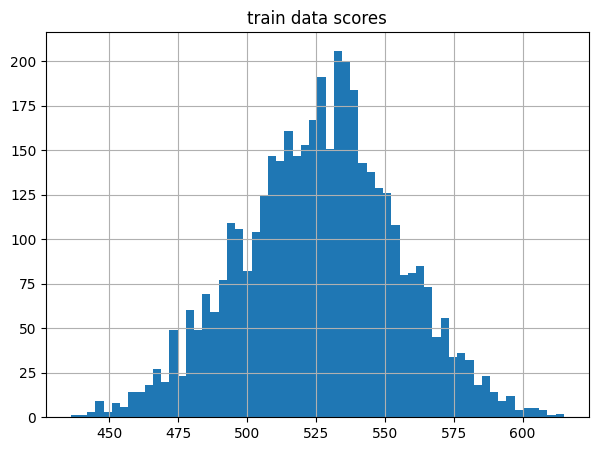

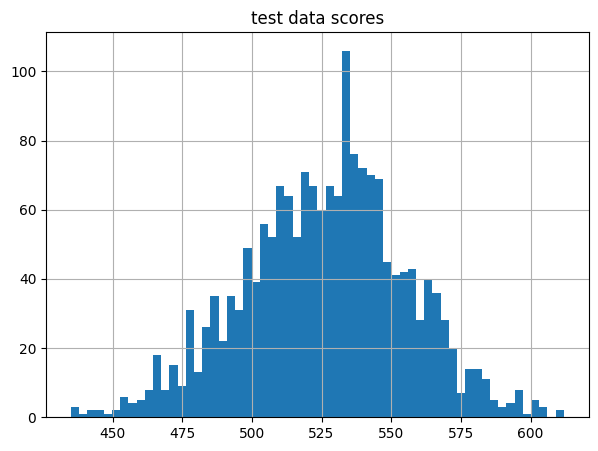

In [160]:
# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

In [162]:
# sample code
# print evaluation metrics of the model
y_pred = lr_bal2.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_pred, y_test))
print("\nPCC measures:")
print(classification_report(y_pred, y_test))

Confusion matrix:
[[1496  100]
 [ 126   56]]

PCC measures:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1596
           1       0.36      0.31      0.33       182

    accuracy                           0.87      1778
   macro avg       0.64      0.62      0.63      1778
weighted avg       0.86      0.87      0.87      1778



In [ ]:
# # sample code 

# evaluate the performance of the logistic regression
train_pred = lr_bal2.predict_proba(X_train)[:,1]
test_pred = lr_bal2.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

In [165]:
# sample code

# calulate credit score for new application
col = ['EXT_SOURCE_3', 
'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 
                'YEARS_EMPLOYED', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'AMT_ANNUITY',
                'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE']
val = [
    [0.7,
    0.555912083,
    0.8,
    -1870,
    10.0,
    551000,
    475000,
    2.0,
    1.0,
    34700.5,
    -2574,
    1.0]]
new_appl = pd.DataFrame(val, columns=col)

new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score=False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary =  pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value','Points']
print(summary)

                                 App Value  Points
EXT_SOURCE_3                      0.700000    54.0
EXT_SOURCE_2                      0.555912    49.0
EXT_SOURCE_1                      0.800000    66.0
DAYS_LAST_PHONE_CHANGE        -1870.000000    45.0
YEARS_EMPLOYED                   10.000000    45.0
AMT_CREDIT                   551000.000000    42.0
AMT_GOODS_PRICE              475000.000000    43.0
REGION_RATING_CLIENT_W_CITY       2.000000    44.0
REGION_RATING_CLIENT              1.000000    42.0
AMT_ANNUITY                   34700.500000    38.0
DAYS_REGISTRATION             -2574.000000    43.0
REGION_POPULATION_RELATIVE        1.000000    43.0
score                                  NaN   554.0


##  -- End of Document --